# Classification of galaxies with emission lines

By: Thara Caba, University of Belgrade

In case of galaxies with emission lines in their spectra, the general problem is how one can reliably classify a galaxy as a starburst galaxy or an active galactic nucleus (AGN). The best way is to provide a classification that is based on different “excitation” mechanism in these objects.

“Baldwin, Phillips & Terlevich” (BPT 1981) diagrams demonstrate how LINERs can be distinguished from normal H II regions and normal AGNs (Seyferts and QSOs) based on their [O III] $\lambda$5007, H$\beta$, [N II] $\lambda$6583, H$\alpha$, [O I] and [S II] $\lambda\lambda$6716, 6731 / H$\alpha$ flux ratios. This is the way how to distinguish between the starburst galaxies and AGN. 

## Task 1

The first project task is to extract top 30,000 galaxies with narrow emission lines with redshift z < 0.35 from the SDSS database (e.g., DR17 or DR18 –http://www.sdss.org/) using the SQL search and produce BPT diagram.

__Task a)__ Obtain the following line fluxes __[O III] $\lambda$ 5007__, __H$\beta$__, __[N II] $\lambda$ 6583__, __H$\alpha$__, __[S II] $\lambda\lambda$6716, 6731__, __[O I] $\lambda$6300__, and equivalent width of __H$\alpha$__ from the SDSS spectral databases _(tips: when selecting galaxies define as one of the criteria that you only need narrow emission line; find a way to calculate line fluxes using only data available in SDSS tables)_. For the division line use the theoretical curves obtained by Kewley et al. (2001) and empirical curves from Kauffman et al. (2003). Make plots for __[O III] $\lambda$5007/H$\beta$__ vs. __[N II] $\lambda$6583/H$\alpha$__, denoting with different marks/colors different object.

In [279]:
# imports

import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from astroquery.sdss import SDSS
from calc_kcor import calc_kcor

In [280]:
# SDSS query through astropy

with open('query.txt', 'r') as file:
    query = file.read().replace('\n', ' ') ## input is a single string

results = SDSS.query_sql(query, timeout=500, data_release=18).to_pandas()

results.to_csv('nlr.csv', sep=',')

In [281]:
# our data

df = pd.read_csv('nlr.csv', sep=',', index_col=0)
df

,plate,mjd,fiberid,class,subclass,z,h_alpha_flux,h_beta_flux,oiii_5007_flux,nii_6584_flux,oi_6300_flux,sii_6717_flux,sii_6731_flux,h_alpha_eqw,nii_6584_eqw
0,266,51602,150,GALAXY,STARFORMING BROADLINE,0.053024,649.9068,138.88450,76.18038,387.02670,77.179630,241.62960,150.10770,-29.93797,-15.975410
1,266,51630,216,GALAXY,AGN BROADLINE,0.067634,472.3678,122.33040,966.63170,547.75610,82.458690,227.84030,183.84240,-11.78250,-12.161400
2,266,51630,370,GALAXY,STARFORMING,0.057360,404.0885,106.46640,53.55283,130.44890,10.492280,86.98476,67.67570,-32.15246,-10.537790
3,266,51602,593,GALAXY,STARFORMING,0.070265,265.4642,65.03958,53.45903,70.29190,14.766860,62.98328,44.46009,-33.20479,-8.992076
4,267,51608,63,GALAXY,STARBURST,0.021397,1253.1030,293.00780,109.82570,380.40870,31.707150,236.29860,164.02120,-55.09866,-16.810270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,470,51929,518,GALAXY,STARFORMING,0.027202,368.1996,110.96300,196.67490,60.50345,17.237680,77.34230,50.77919,-34.55486,-5.403984
29996,471,51924,100,GALAXY,STARFORMING,0.053758,309.4774,78.90777,44.28101,155.87700,16.156810,69.59632,53.24332,-13.09887,-6.450426
29997,472,51955,16,GALAXY,STARFORMING,0.056280,355.0509,74.23045,50.72155,155.29090,18.944540,77.74780,59.35276,-20.28308,-8.812138
29998,472,51955,415,GALAXY,STARBURST,0.180518,519.3710,135.24320,45.94009,222.90800,16.894580,77.16412,64.07111,-42.11248,-18.339360


In [282]:
df.columns

Index(['plate', 'mjd', 'fiberid', 'class', 'subclass', 'z', 'h_alpha_flux',
       'h_beta_flux', 'oiii_5007_flux', 'nii_6584_flux', 'oi_6300_flux',
       'sii_6717_flux', 'sii_6731_flux', 'h_alpha_eqw', 'nii_6584_eqw'],
      dtype='object')

In [283]:
# class distribution

df['class'].value_counts()

GALAXY    29742
QSO         258
Name: class, dtype: int64

In [284]:
# subclass distribution

df['subclass'].value_counts()

STARFORMING              13935
STARBURST                12717
AGN                       1964
AGN BROADLINE              204
BROADLINE                  108
STARBURST BROADLINE         88
STARFORMING BROADLINE       40
Name: subclass, dtype: int64

In [285]:
# BPT division lines

x = np.linspace(-1.5, 1.1, 1000)
y_kauffmann = 0.61/(x-0.05) + 1.3
y_kewley = 0.61/(x-0.47) + 1.19

# division lines as a function to make it single valued in our limits

def kauffman(x):
    ## x lim was calculated for a y of -1.5
    return [0.61/(i-0.05) + 1.3 if (i < (0.61/(-1.5-1.3))+0.05) else -np.inf for i in x] 

def kewley(x):
   ## x lim was calculated for a y of -1.5 
   return [0.61/(i-0.47) + 1.19 if (i < (0.61/(-1.5-1.19))+0.47) else -np.inf for i in x] 

In [316]:
# BPT classification

def bpt_classifier(df):
    df['x_BPT'] = np.log10(df['nii_6584_flux']/df['h_alpha_flux'])
    df['y_BPT'] = np.log10(df['oiii_5007_flux']/df['h_beta_flux'])
    df['class_Kauffmann'] = np.where((df['y_BPT'] <= kauffman(df['x_BPT'])), "SFG", "QSO")
    df['class_Kewley'] = np.where((df['y_BPT'] <= kewley(df['x_BPT'])), "SFG", "QSO")
    df['class_BPT'] = np.where(((df['class_Kauffmann']=='SFG')&(df['class_Kewley']=='SFG')), "SFG", 
                                    np.where(((df['class_Kauffmann']=='QSO')&(df['class_Kewley']=='QSO')), "AGN", 
                                            "composite"))
    return df

def bpt_plt(df):

    fig = plt.figure()

    x = df['x_BPT']
    y = df['y_BPT']
    xy = np.vstack([x,y])
    df["kde"] = gaussian_kde(xy)(xy)

    class_dict = {'SFG': plt.cm.Wistia, 
                  'composite': plt.cm.Greens, 
                  'AGN': plt.cm.spring
                  }
    
    for class_gal in class_dict.keys():
        df_sub = df[df['class_BPT'] == class_gal]
        x_sub = df_sub['x_BPT']
        y_sub = df_sub['y_BPT']
        z_sub = df_sub['kde']
        normalize = matplotlib.colors.Normalize(vmin=-1, vmax=1)
        plt.scatter(x_sub, y_sub, c=z_sub, s=5, edgecolor=None,
                    cmap=class_dict[class_gal], norm=normalize)
    
    x = np.linspace(np.min(df['x_BPT']),np.max( df['x_BPT']), 1000)
    plt.plot(x, kauffman(x), 'k--', label="Kauffmann")
    plt.plot(x, kewley(x), 'k:', label="Kewley")

    scatter1 = plt.scatter([], [], c='#FFA500', label="SFG")
    scatter2 = plt.scatter([], [], c='green', label="composite")
    scatter3 = plt.scatter([], [], c='#FFC0CB', label="AGN")
    
   # Add the legend for scatter plot markers and lines
    handles = [plt.Line2D([], [], color='black', linestyle='--', label='Kauffmann'),
               plt.Line2D([], [], color='black', linestyle=':', label='Kewley'), scatter3, scatter2, scatter1]
    plt.legend(handles=handles, labels=["Kauffmann", "Kewley", "AGN", "composite", "SFG"],
               loc='lower left', title="BPT classification", fontsize='medium')
    
    plt.title('BPT diagram')
    plt.xlabel(r"log ([NII]/H$\alpha$)", fontsize=12)
    plt.ylabel(r"log ([OIII]/H$\beta$)", fontsize=12)
    plt.subplots_adjust(hspace=.0)
    
    return fig

In [287]:
df = bpt_classifier(df)

In [288]:
df

,plate,mjd,fiberid,class,subclass,z,h_alpha_flux,h_beta_flux,oiii_5007_flux,nii_6584_flux,oi_6300_flux,sii_6717_flux,sii_6731_flux,h_alpha_eqw,nii_6584_eqw,x_BPT,y_BPT,class_Kauffmann,class_Kewley,class_BPT
0,266,51602,150,GALAXY,STARFORMING BROADLINE,0.053024,649.9068,138.88450,76.18038,387.02670,77.179630,241.62960,150.10770,-29.93797,-15.975410,-0.225110,-0.260811,QSO,SFG,composite
1,266,51630,216,GALAXY,AGN BROADLINE,0.067634,472.3678,122.33040,966.63170,547.75610,82.458690,227.84030,183.84240,-11.78250,-12.161400,0.064307,0.897727,QSO,QSO,AGN
2,266,51630,370,GALAXY,STARFORMING,0.057360,404.0885,106.46640,53.55283,130.44890,10.492280,86.98476,67.67570,-32.15246,-10.537790,-0.491036,-0.298430,SFG,SFG,SFG
3,266,51602,593,GALAXY,STARFORMING,0.070265,265.4642,65.03958,53.45903,70.29190,14.766860,62.98328,44.46009,-33.20479,-8.992076,-0.577101,-0.085157,SFG,SFG,SFG
4,267,51608,63,GALAXY,STARBURST,0.021397,1253.1030,293.00780,109.82570,380.40870,31.707150,236.29860,164.02120,-55.09866,-16.810270,-0.517736,-0.426175,SFG,SFG,SFG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,470,51929,518,GALAXY,STARFORMING,0.027202,368.1996,110.96300,196.67490,60.50345,17.237680,77.34230,50.77919,-34.55486,-5.403984,-0.784303,0.248571,SFG,SFG,SFG
29996,471,51924,100,GALAXY,STARFORMING,0.053758,309.4774,78.90777,44.28101,155.87700,16.156810,69.59632,53.24332,-13.09887,-6.450426,-0.297847,-0.250902,QSO,SFG,composite
29997,472,51955,16,GALAXY,STARFORMING,0.056280,355.0509,74.23045,50.72155,155.29090,18.944540,77.74780,59.35276,-20.28308,-8.812138,-0.359145,-0.165390,QSO,SFG,composite
29998,472,51955,415,GALAXY,STARBURST,0.180518,519.3710,135.24320,45.94009,222.90800,16.894580,77.16412,64.07111,-42.11248,-18.339360,-0.367352,-0.468924,SFG,SFG,SFG


In [289]:
df['class_Kauffmann'].value_counts()

SFG    23524
QSO     6476
Name: class_Kauffmann, dtype: int64

In [290]:
df['class_Kewley'].value_counts()

SFG    27175
QSO     2825
Name: class_Kewley, dtype: int64

In [291]:
df['class_BPT'].value_counts()

SFG          23524
composite     3651
AGN           2825
Name: class_BPT, dtype: int64

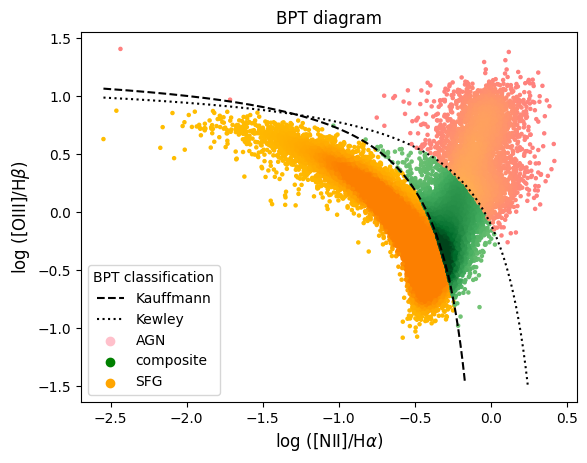

In [292]:
fig = bpt_plt(bpt_classifier(df))
fig.savefig('bpt_classic.pdf', dpi=100);

__task b)__ Test is there a cosmic evolution of the BPT diagram (see e.g., Kewley et a. 2013) by plotting the BPT diagrams for different redshift bins (e.g., $\Delta$z = 0.05 or 0.1). Could you notice the change in the distribution of objects across the BPT plane? How would you explain this cosmic evolution? Think of another way to present (and compare) distributions of different sub-samples.

In [293]:
# Define redshift bins (example: bin size of 0.1)
redshift_bins = np.arange(0, 1, 0.1)

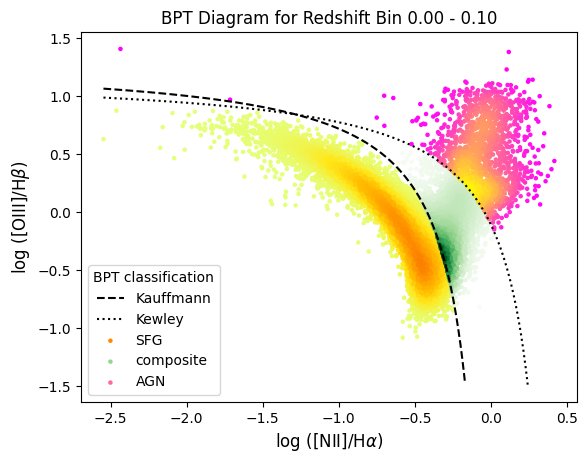

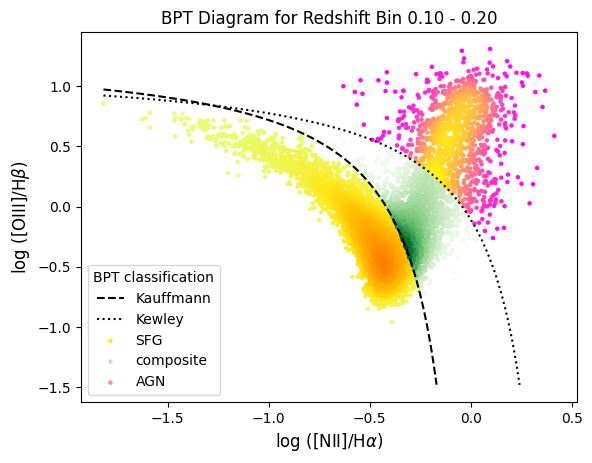

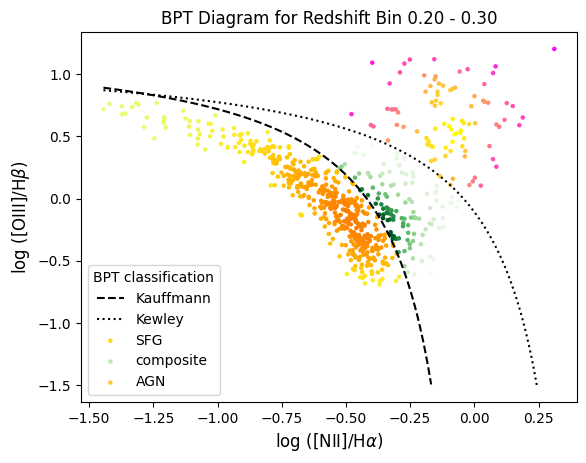

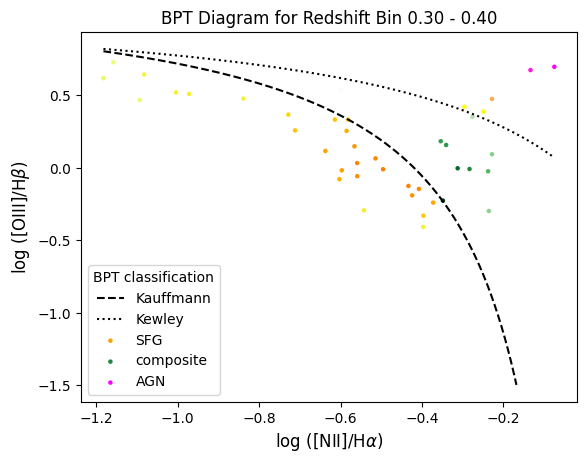

In [314]:
# BPT plot function with redshift bin argument
def bpt_plt2(df, redshift_bin):
    fig, ax = plt.subplots()
    
    x = df['x_BPT']
    y = df['y_BPT']
    xy = np.vstack([x, y])
    df["kde"] = gaussian_kde(xy)(xy)

    class_dict = {
        'SFG': 'Wistia',
        'composite': 'Greens',
        'AGN': 'spring'
    }

    for class_gal, cmap in class_dict.items():
        df_sub = df[df['class_BPT'] == class_gal]
        x_sub = df_sub['x_BPT']
        y_sub = df_sub['y_BPT']
        z_sub = df_sub['kde']
        normalize = matplotlib.colors.Normalize(vmin=z_sub.min(), vmax=z_sub.max())
        ax.scatter(x_sub, y_sub, c=z_sub, s=5, edgecolor=None, cmap=cmap, norm=normalize, label=class_gal)
    
    x = np.linspace(np.min(df['x_BPT']), np.max(df['x_BPT']), 1000)
    ax.plot(x, kauffman(x), 'k--', label="Kauffmann")
    ax.plot(x, kewley(x), 'k:', label="Kewley")

    ax.set_title(f'BPT Diagram for Redshift Bin {redshift_bin[0]:.2f} - {redshift_bin[1]:.2f}')
    ax.set_xlabel(r"log ([NII]/H$\alpha$)", fontsize=12)
    ax.set_ylabel(r"log ([OIII]/H$\beta$)", fontsize=12)
    ax.legend(loc='lower left', title="BPT classification", fontsize='medium')
    
    return fig

# Define redshift bins (example: bin size of 0.1)
redshift_bins = np.arange(0, 1, 0.1)

# Iterate over each redshift bin, classify and plot
for z_min, z_max in zip(redshift_bins[:-1], redshift_bins[1:]):
    df_bin = df[(df['z'] >= z_min) & (df['z'] < z_max)]
    if df_bin.empty:
        continue
    df_classified = bpt_classifier(df_bin)
    fig = bpt_plt(df_classified, (z_min, z_max))
    fig.savefig(f'bpt_classic_{z_min:.2f}_{z_max:.2f}.pdf', dpi=100)
    #plt.close(fig)  # Close the figure to avoid display issues in loops


We notice a change in the distribution of objects across the BPT plane depending on the redshift. The larger the redshift less objects we see. This cosmic evolution could be due to observational bias since as the redshift increases, the apparent brightness of objects decreases due to cosmological redshift. This can make it more challenging to detect faint objects at higher redshifts, leading to a decrease in the number of observed objects. 

To think of another way to present (and compare) distributions of different sub-samples we can create stacked bar plots to show the distribution of different BPT classifications within each redshift bin. This way, we can visualize the proportion of galaxies, AGN, and composite galaxies in each redshift bin.

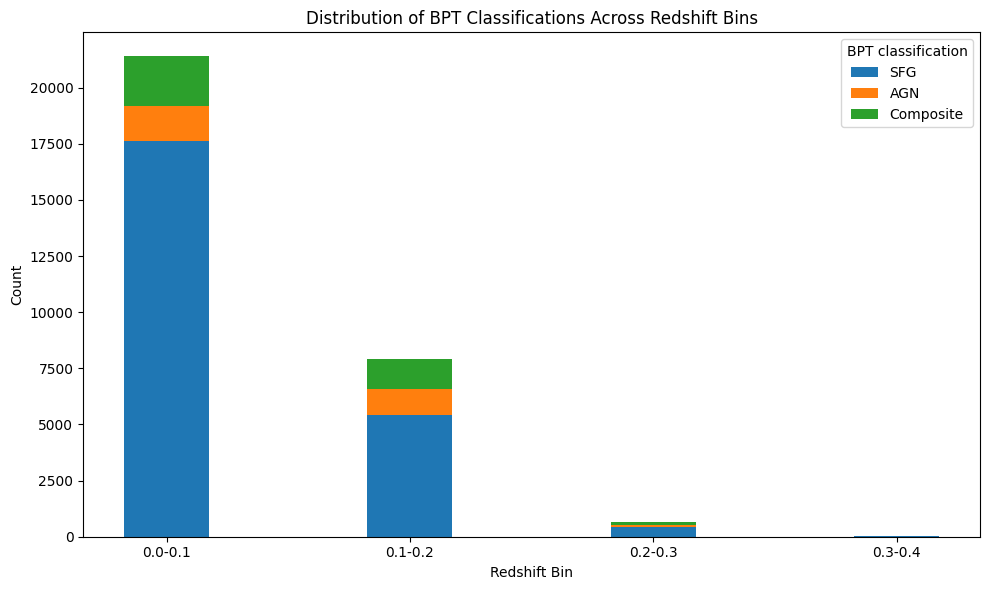

In [296]:
# Create a stacked bar plot for BPT classifications within each redshift bin
fig, ax = plt.subplots(figsize=(10, 6))

redshift_bins = np.arange(0, 0.5, 0.1)

# Initialize variables to store the counts of each BPT classification
sfg_counts = []
agn_counts = []
composite_counts = []

# Iterate over redshift bins
for i in range(len(redshift_bins) - 1):
    z_min, z_max = redshift_bins[i], redshift_bins[i + 1]
    
    # Filter the DataFrame for the current redshift bin
    df_bin = df[(df['z'] >= z_min) & (df['z'] < z_max)]
    
    # Count the occurrences of each BPT classification within the bin
    sfg_count = df_bin[df_bin['class_BPT'] == 'SFG'].shape[0]
    agn_count = df_bin[df_bin['class_BPT'] == 'AGN'].shape[0]
    composite_count = df_bin[df_bin['class_BPT'] == 'composite'].shape[0]
    
    # Append the counts to the respective lists
    sfg_counts.append(sfg_count)
    agn_counts.append(agn_count)
    composite_counts.append(composite_count)

# Plot stacked bar plots
bar_width = 0.35
bins_labels = [f'{z_min:.1f}-{z_max:.1f}' for z_min, z_max in zip(redshift_bins[:-1], redshift_bins[1:])]
index = range(len(redshift_bins) - 1)

p1 = ax.bar(index, sfg_counts, bar_width, label='SFG', color='tab:blue')
p2 = ax.bar(index, agn_counts, bar_width, bottom=sfg_counts, label='AGN', color='tab:orange')
p3 = ax.bar(index, composite_counts, bar_width, bottom=[sfg + agn for sfg, agn in zip(sfg_counts, agn_counts)], label='Composite', color='tab:green')

# Add labels, title, and legend
ax.set_xlabel('Redshift Bin')
ax.set_ylabel('Count')
ax.set_title('Distribution of BPT Classifications Across Redshift Bins')
ax.set_xticks(index)
ax.set_xticklabels(bins_labels)
ax.legend(title='BPT classification')
plt.tight_layout()
plt.show()

In [297]:
# Initialize a dictionary to store the counts for each BPT classification within each redshift bin
counts_per_bin = {}

# Iterate over redshift bins
for i in range(len(redshift_bins) - 1):
    z_min, z_max = redshift_bins[i], redshift_bins[i + 1]
    
    # Filter the DataFrame for the current redshift bin
    df_bin = df[(df['z'] >= z_min) & (df['z'] < z_max)]
    
    # Count the occurrences of each BPT classification within the bin
    sfg_count = df_bin[df_bin['class_BPT'] == 'SFG'].shape[0]
    agn_count = df_bin[df_bin['class_BPT'] == 'AGN'].shape[0]
    composite_count = df_bin[df_bin['class_BPT'] == 'composite'].shape[0]
    
    # Store the counts in the dictionary
    counts_per_bin[f'{z_min}-{z_max}'] = {'SFG': sfg_count, 'AGN': agn_count, 'Composite': composite_count}

# Print the counts
for bin_range, counts in counts_per_bin.items():
    print(f'Redshift Bin: {bin_range}')
    print(f'SFG count: {counts["SFG"]}, AGN count: {counts["AGN"]}, Composite count: {counts["Composite"]}')
    print()


Redshift Bin: 0.0-0.1
SFG count: 17613, AGN count: 1583, Composite count: 2201

Redshift Bin: 0.1-0.2
SFG count: 5435, AGN count: 1147, Composite count: 1321

Redshift Bin: 0.2-0.30000000000000004
SFG count: 449, AGN count: 90, Composite count: 119

Redshift Bin: 0.30000000000000004-0.4
SFG count: 27, AGN count: 5, Composite count: 10



In [298]:
# Initialize dictionaries to store the ratios for each BPT classification within each redshift bin
ratios_per_bin = {}

# Iterate over redshift bins
for bin_range, counts in counts_per_bin.items():
    sfg_count = counts['SFG']
    agn_count = counts['AGN']
    composite_count = counts['Composite']
    
    # Calculate the ratio for each BPT classification within the bin
    sfg_ratio = sfg_count / (sfg_count + agn_count + composite_count)
    agn_ratio = agn_count / (sfg_count + agn_count + composite_count)
    composite_ratio = composite_count / (sfg_count + agn_count + composite_count)
    
    # Store the ratios in the dictionary
    ratios_per_bin[bin_range] = {'SFG': sfg_ratio, 'AGN': agn_ratio, 'Composite': composite_ratio}

# Print the ratios
for bin_range, ratios in ratios_per_bin.items():
    print(f'Redshift Bin: {bin_range}')
    print(f'SFG ratio: {ratios["SFG"]:.2f}, AGN ratio: {ratios["AGN"]:.2f}, Composite ratio: {ratios["Composite"]:.2f}')
    print()

Redshift Bin: 0.0-0.1
SFG ratio: 0.82, AGN ratio: 0.07, Composite ratio: 0.10

Redshift Bin: 0.1-0.2
SFG ratio: 0.69, AGN ratio: 0.15, Composite ratio: 0.17

Redshift Bin: 0.2-0.30000000000000004
SFG ratio: 0.68, AGN ratio: 0.14, Composite ratio: 0.18

Redshift Bin: 0.30000000000000004-0.4
SFG ratio: 0.64, AGN ratio: 0.12, Composite ratio: 0.24



Some potential physical reason for the ratios we are observing:

__Evolution of Galaxy Populations__: The changing ratios across redshift bins could reflect the evolution of galaxy populations over cosmic time. For example, the decreasing proportion of SFGs and increasing proportion of Composites with increasing redshift may suggest a transition in the dominant types of galaxies, such as the decline of star-forming galaxies and the emergence of more active galactic nuclei (AGN)-dominated galaxies.

__task c)__ Test the classification obtained using the first BPT diagnostics [OIII]$\lambda$5007/H$\beta$ vs. [NII]$\lambda$6584/H$\alpha$, with the other two common BPT diagnostic tools: 1) __[OIII]$\lambda$5007/H$\beta$ vs. [SII]$\lambda\lambda$6716,6731/H$\alpha$__, 2) __[OIII]$\lambda$5007/H$\beta$ vs. [OI]$\lambda$6300/H$\alpha$__. _(Tip: use the same mark/color notation as for the first diagnostic in order to be able to make comparison)_.

SFG    28029
QSO     1971
Name: class_Kewley_si, dtype: int64


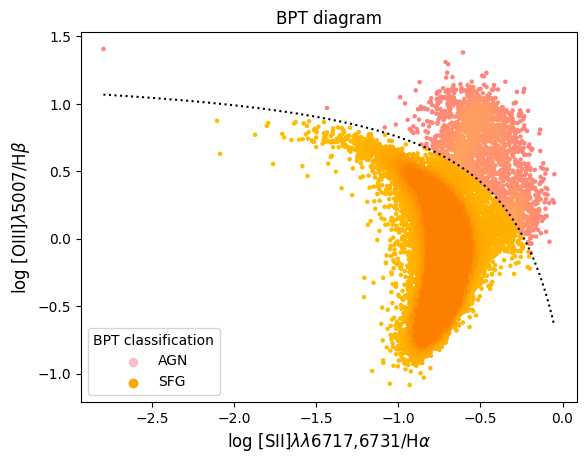

In [299]:
# BPT  diagram - [OIII]λ5007/Hβ vs. [SII]λλ6716,6731/Hα

df2=df

# division line as a function to make it single valued in our limits

def kewley_si(x):
   ## x was calculated for a y of -1.5
   return [0.72/(i-0.32) + 1.30 if (i < (0.72/(-1.5-1.3))+0.32) else -np.inf for i in x] 

df['x_BPT'] = np.log10(df['sii_6717_flux']/df['h_alpha_flux'])
df['y_BPT'] = np.log10(df['oiii_5007_flux']/df['h_beta_flux'])
df['class_Kewley_si'] = np.where((df['y_BPT'] <= kewley_si(df['x_BPT'])), "SFG", "QSO")

print(df['class_Kewley_si'].value_counts())

fig = plt.figure()

x = df['x_BPT']
y = df['y_BPT']
xy = np.vstack([x,y])
df["kde"] = gaussian_kde(xy)(xy)

class_dict = {'SFG': plt.cm.Wistia, 
                'QSO': plt.cm.spring
                }

for class_gal in class_dict.keys():
    df_sub = df[df['class_Kewley_si'] == class_gal]
    x_sub = df_sub['x_BPT']
    y_sub = df_sub['y_BPT']
    z_sub = df_sub['kde']
    normalize = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    plt.scatter(x_sub, y_sub, c=z_sub, s=5, edgecolor=None,
                cmap=class_dict[class_gal], norm=normalize)

x = np.linspace(np.min(df['x_BPT']),np.max( df['x_BPT']), 1000)
plt.plot(x, kewley_si(x), 'k:', label="Kewley_si")

scatter1 = plt.scatter([], [], c='#FFA500', label="SFG")
scatter3 = plt.scatter([], [], c='#FFC0CB', label="QSO")
plt.title('BPT diagram')
plt.legend((scatter3, scatter1), ["AGN", "SFG"], 
            loc='lower left', title="BPT classification", fontsize='medium')
plt.xlabel(r"log [SII]$\lambda$$\lambda$6717,6731/H$\alpha$", fontsize=12)
plt.ylabel(r"log [OIII]$\lambda$5007/H$\beta$", fontsize=12)
plt.subplots_adjust(hspace=.0)

fig.savefig("bpt_oiii_sii.pdf", dpi=100);

There are less AGNs than with the standard Kewley. 

SFG    25678
QSO     4322
Name: class_Kewley_oi, dtype: int64


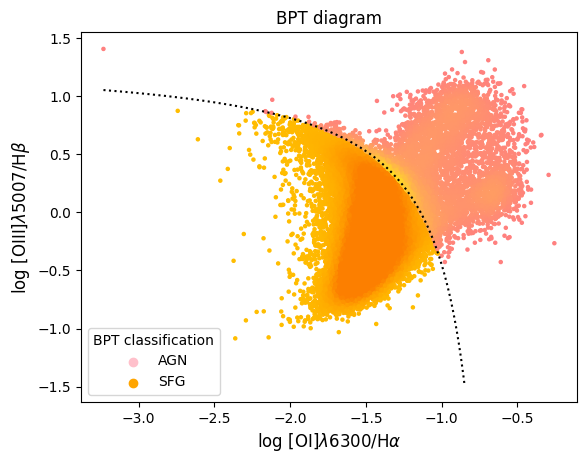

In [300]:
# BPT  diagram - [OIII]λ5007/Hβ vs. [OI]λ6300/Hα

df3=df

# division line as a function to make it single valued in our limits

def kewley_oi(x):
   ## x was calculated for a y of -1.5
   return [0.73/(i+0.59) + 1.33 if (i < (0.73/(-1.5-1.33))-0.59) else -np.inf for i in x] 

df['x_BPT'] = np.log10(df['oi_6300_flux']/df['h_alpha_flux'])
df['y_BPT'] = np.log10(df['oiii_5007_flux']/df['h_beta_flux'])
df['class_Kewley_oi'] = np.where((df['y_BPT'] <= kewley_oi(df['x_BPT'])), "SFG", "QSO")

print(df['class_Kewley_oi'].value_counts())

fig = plt.figure()

x = df['x_BPT']
y = df['y_BPT']
xy = np.vstack([x,y])
df["kde"] = gaussian_kde(xy)(xy)

class_dict = {'SFG': plt.cm.Wistia, 
                'QSO': plt.cm.spring
                }

for class_gal in class_dict.keys():
    df_sub = df[df['class_Kewley_oi'] == class_gal]
    x_sub = df_sub['x_BPT']
    y_sub = df_sub['y_BPT']
    z_sub = df_sub['kde']
    normalize = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    plt.scatter(x_sub, y_sub, c=z_sub, s=5, edgecolor=None,
                cmap=class_dict[class_gal], norm=normalize)

x = np.linspace(np.min(df['x_BPT']),np.max( df['x_BPT']), 1000)
plt.plot(x, kewley_oi(x), 'k:', label="Kewley_oi")

scatter1 = plt.scatter([], [], c='#FFA500', label="SFG")
scatter3 = plt.scatter([], [], c='#FFC0CB', label="QSO")
plt.title('BPT diagram')
plt.legend((scatter3, scatter1), ["AGN", "SFG"], 
            loc='lower left', title="BPT classification", fontsize='medium')
plt.xlabel(r"log [OI]$\lambda$6300/H$\alpha$", fontsize=12)
plt.ylabel(r"log [OIII]$\lambda$5007/H$\beta$", fontsize=12)
plt.subplots_adjust(hspace=.0)

fig.savefig("bpt_oiii_oi.pdf", dpi=100);

There are more AGNs than with the standard Kewley. 

__task d)__ Make a WHAN diagram, the __equivalent width of H$\alpha$ (WH$\alpha$) vs. [N II]/H$\alpha$ ratio__, for the objects already classified (keep the same notation, i.e., the classification information obtained in the BPT diagram). Comment and discuss the obtained results, give the number/percentage of objects classified as (strong) AGN/Seyferts by the BPT and WHAN diagrams.

In [301]:
# WHAN classification

gal = bpt_classifier(df)

gal['y_WHAN'] = np.abs(gal['h_alpha_eqw'])
gal['z_WHAN'] = np.abs(gal['nii_6584_eqw'])

gal['group_WHAN'] = np.where(((gal['z_WHAN']>0.5) & (gal['y_WHAN']>0.5)), "ELG", "lineless")

for i in gal.index:
    if gal.loc[i, 'y_WHAN'] > 0.5:
        if gal.loc[i, 'group_WHAN'] != "lineless":
            if gal.loc[i, 'y_WHAN'] > 3:
                if gal.loc[i, 'x_BPT'] > -0.4:
                    if gal.loc[i, 'y_WHAN'] > 6:
                        gal.loc[i, 'subclass_WHAN'] = "Seyfert"
                        gal.loc[i, 'class_WHAN'] = "AGN"
                    else:
                        gal.loc[i, 'subclass_WHAN'] = "wAGN"
                        gal.loc[i, 'class_WHAN'] = "LINER"
                else:
                    gal.loc[i, 'subclass_WHAN'] = "SFG" 
                    gal.loc[i, 'class_WHAN'] = "SFG"           
            else:
                gal.loc[i, 'subclass_WHAN'] = "RG"
                gal.loc[i, 'class_WHAN'] = "LINER"
        else:
            gal.loc[i, 'subclass_WHAN'] = "uncertain"
            gal.loc[i, 'class_WHAN'] = "uncertain"
    else:
        gal.loc[i, 'subclass_WHAN'] = "passive"

In [302]:
gal['group_WHAN'].value_counts()

ELG         29990
lineless       10
Name: group_WHAN, dtype: int64

In [303]:
gal['class_WHAN'].value_counts()

SFG          20845
AGN           8301
LINER          844
uncertain       10
Name: class_WHAN, dtype: int64

In [304]:
gal['subclass_WHAN'].value_counts()

SFG          20845
Seyfert       8301
wAGN           654
RG             190
uncertain       10
Name: subclass_WHAN, dtype: int64

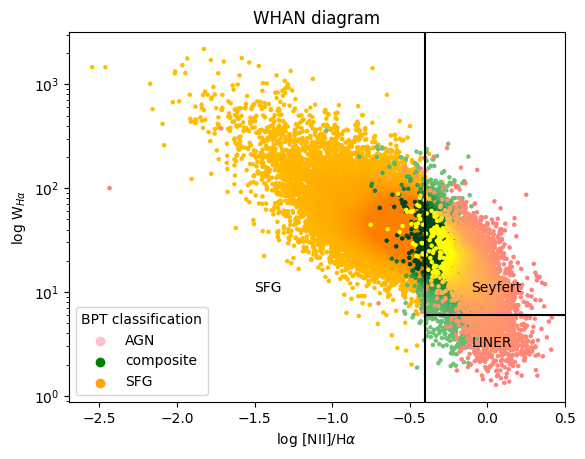

In [305]:
# WHAN diagram

df = gal
x = df['x_BPT']
y = np.log10(df['y_WHAN'])
xy = np.vstack([x,y])
df['kde'] = gaussian_kde(xy)(xy)

class_dict = {'SFG': plt.cm.Wistia, 
              'composite': plt.cm.Greens, 
              'AGN': plt.cm.spring
              }
    
for class_gal in class_dict.keys():
    df_sub = df[df['class_BPT'] == class_gal]
    x_sub = df_sub['x_BPT']
    y_sub = df_sub['y_WHAN']
    z_sub = df_sub['kde']
    normalize = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    plt.scatter(x_sub, y_sub, c=z_sub, s=5, edgecolor=None,
                cmap=class_dict[class_gal], norm=normalize)

plt.axvline(x=-0.4, color='black')
plt.hlines(y=6, xmin=-0.4, xmax=0.5, color='black')
plt.annotate('Seyfert', xy=(-0.1,10), color='black')
plt.annotate('LINER', xy=(-0.1,3), color='black')
plt.annotate('SFG', xy=(-1.5,10), color='black')
plt.yscale('log')
plt.xlim(right=0.5)

scatter1 = plt.scatter([], [], c='#FFA500', label="SFG")
scatter2 = plt.scatter([], [], c='green', label="composite")
scatter3 = plt.scatter([], [], c='#FFC0CB', label="AGN")
plt.legend((scatter3, scatter2, scatter1), ["AGN", "composite", "SFG"], 
            loc='lower left', title="BPT classification", fontsize='medium')

plt.xlabel(r"log [NII]/H$\alpha$")
plt.ylabel(r"log W$_{H\alpha}$")
plt.title("WHAN diagram")
plt.savefig('whan.pdf', dpi=100);

In [306]:
df

,plate,mjd,fiberid,class,subclass,z,h_alpha_flux,h_beta_flux,oiii_5007_flux,nii_6584_flux,...,class_Kewley,class_BPT,kde,class_Kewley_si,class_Kewley_oi,y_WHAN,z_WHAN,group_WHAN,subclass_WHAN,class_WHAN
0,266,51602,150,GALAXY,STARFORMING BROADLINE,0.053024,649.9068,138.88450,76.18038,387.02670,...,SFG,composite,0.837250,SFG,QSO,29.93797,15.975410,ELG,Seyfert,AGN
1,266,51630,216,GALAXY,AGN BROADLINE,0.067634,472.3678,122.33040,966.63170,547.75610,...,QSO,AGN,0.217964,QSO,QSO,11.78250,12.161400,ELG,Seyfert,AGN
2,266,51630,370,GALAXY,STARFORMING,0.057360,404.0885,106.46640,53.55283,130.44890,...,SFG,SFG,4.079696,SFG,SFG,32.15246,10.537790,ELG,SFG,SFG
3,266,51602,593,GALAXY,STARFORMING,0.070265,265.4642,65.03958,53.45903,70.29190,...,SFG,SFG,2.423380,SFG,SFG,33.20479,8.992076,ELG,SFG,SFG
4,267,51608,63,GALAXY,STARBURST,0.021397,1253.1030,293.00780,109.82570,380.40870,...,SFG,SFG,2.652873,SFG,SFG,55.09866,16.810270,ELG,SFG,SFG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,470,51929,518,GALAXY,STARFORMING,0.027202,368.1996,110.96300,196.67490,60.50345,...,SFG,SFG,0.750063,SFG,SFG,34.55486,5.403984,ELG,SFG,SFG
29996,471,51924,100,GALAXY,STARFORMING,0.053758,309.4774,78.90777,44.28101,155.87700,...,SFG,composite,0.679305,SFG,SFG,13.09887,6.450426,ELG,Seyfert,AGN
29997,472,51955,16,GALAXY,STARFORMING,0.056280,355.0509,74.23045,50.72155,155.29090,...,SFG,composite,1.793210,SFG,SFG,20.28308,8.812138,ELG,Seyfert,AGN
29998,472,51955,415,GALAXY,STARBURST,0.180518,519.3710,135.24320,45.94009,222.90800,...,SFG,SFG,2.233287,SFG,SFG,42.11248,18.339360,ELG,Seyfert,AGN


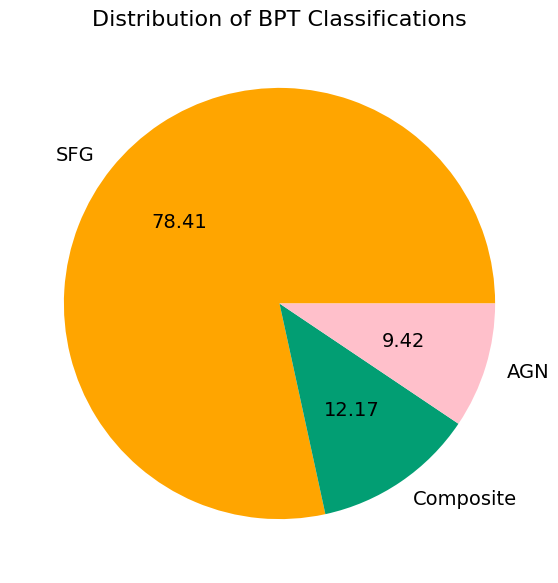

In [307]:
# Count the occurrences of each BPT classification
bpt_counts = df['class_BPT'].value_counts()

# Plot the pie chart
plt.figure(figsize=(7, 7))
bpt_counts.plot(kind='pie', autopct='%.2f', 
                textprops={'fontsize': 14}, 
                colors=['#FFA500', '#029e73', '#FFC0CB'],
                labels=['SFG', 'Composite', 'AGN'])

plt.ylabel('')
plt.title('Distribution of BPT Classifications', fontsize=16)
plt.show()

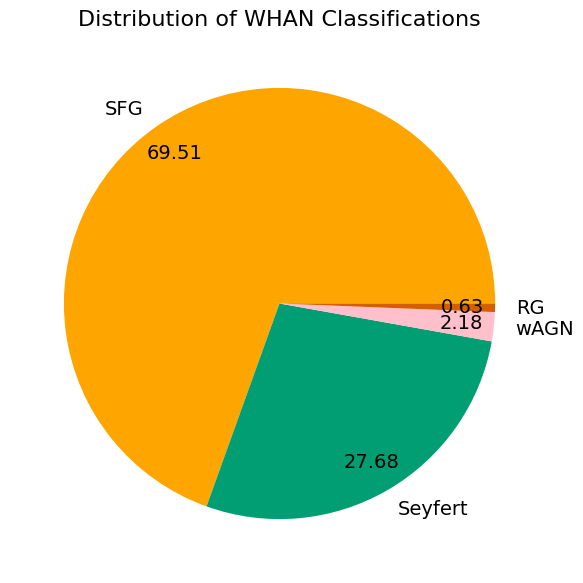

In [308]:
import matplotlib.pyplot as plt

# Count the occurrences of each WHAN classification
whan_counts = df['subclass_WHAN'].value_counts()

# Filter out the 'uncertain' category
whan_counts = whan_counts[whan_counts.index != 'uncertain']

# Define colorblind-friendly colors for the remaining categories
colors = ['#FFA500', '#029e73', '#FFC0CB', '#d55e00']  # Orange, Green, Pink, and Red

# Plot the pie chart
plt.figure(figsize=(7, 7))
plt.pie(whan_counts, autopct='%.2f', 
        textprops={'fontsize': 14}, 
        colors=colors, labels=whan_counts.index,
        pctdistance=0.85, labeldistance=1.1)

plt.title('Distribution of WHAN Classifications', fontsize=16)
plt.show()


We have more AGNs in the WHAN diagram.

## Task 2

For a subsample of these SDSS objects, there are also __[Ne III] $\lambda$3869 and [O II] $\lambda\lambda$3726,3729__ line fluxes available _(tip: set S/N ratio to at least 5)_. Extract that subsample from the first sample, together with their g, z magnitudes and above line fluxes. Make the BPT and TBT diagrams for this subsample, keeping the same notation (i.e., use the classification information obtained in the BPT diagram for the TBT diagram). The observed magnitudes should be transformed to the z=0 frame using k-correction (Chilingarian et al. 2010, http://kcor.sai.msu.ru/ or Blanton & Roweis 2007, http://kcorrect.org/). The division line on the TBT diagram is as follows:

$(g-z)_0 = -1.2 \times log([NeIII]/[OII]) - 0.4$

where $(g-z)_0$ is the rest-frame g-z color, [NeIII] is the line flux of [Ne III] $\lambda$3869 and [OII] is the
line flux of the [OII] $\lambda\lambda$3726,3729 doublet (sometimes labeled as [OII] $\lambda$3727 when the doublet components are not resolved). Comment on what is the number/percentage of objects defined as AGN by BPT, TBT and both BPT and TBT diagrams.

In [309]:
# sdss query through astropy

with open('query2.txt', 'r') as file:
    query = file.read().replace('\n', ' ') ## input is a single string

results_sub = SDSS.query_sql(query, timeout=500, data_release=18).to_pandas()

results_sub.to_csv('nlr_sub.csv', sep=',')

In [310]:
# our data

gal_sub = pd.read_csv('nlr_sub.csv', sep=',', index_col=0)
gal_sub

,plate,mjd,fiberid,z,subclass,e_bv_sfd,h_alpha_flux,h_beta_flux,oiii_5007_flux,nii_6584_flux,oi_6300_flux,sii_6717_flux,sii_6731_flux,neiii_3869_flux,oii_3726_flux,oii_3729_flux,h_alpha_eqw,nii_6584_eqw,psfMag_g,psfMag_z
0,296,51665,491,0.085036,AGN,0.023489,1253.4950,306.65060,1444.67600,1108.32700,83.744950,211.47090,192.65070,135.50170,209.15550,146.2352,-46.04132,-38.677480,17.96900,17.02561
1,296,51984,498,0.085015,AGN,0.023489,1365.6810,314.73870,1547.96600,1242.83200,88.342490,220.78300,221.34700,139.63960,225.55110,142.0732,-49.91815,-42.064200,17.96900,17.02561
2,296,51665,411,0.047694,STARBURST,0.033924,2188.5300,691.68790,3675.75900,93.97952,29.441700,123.39190,95.64021,265.31280,672.35190,817.9950,-327.70230,-16.730940,18.56843,18.60574
3,296,51984,416,0.047686,STARBURST,0.033924,2224.1920,697.24840,3588.17100,97.43239,32.892170,138.30570,102.04920,270.92750,667.79490,859.9167,-320.50340,-14.904840,18.56843,18.60574
4,296,51984,536,0.071277,STARFORMING,0.025706,323.8659,82.13303,44.47351,97.82665,10.625460,69.34225,44.45137,14.56609,85.56854,118.1344,-36.37411,-11.085650,19.47467,18.38963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20309,708,52175,531,0.105992,NaN,0.088698,498.8019,152.49180,619.91000,30.79363,13.447070,45.60392,35.09238,41.33839,163.30940,218.8852,-158.83280,-13.179550,20.37039,20.54704
20310,1026,52558,456,0.070713,STARBURST,0.143083,263.0945,79.77567,95.04425,53.54069,10.376360,53.59843,40.47249,13.42949,129.07560,136.9735,-41.47359,-8.057358,20.32859,19.46003
20311,708,52175,404,0.027945,STARBURST,0.067987,1108.5060,396.04620,2902.58200,20.50705,7.681569,39.04944,30.10690,220.04040,244.09360,276.3548,-384.61920,-8.281638,19.45025,19.89397
20312,454,51908,570,0.058800,STARBURST,0.026819,3588.8860,983.52810,1162.26700,775.88980,108.456000,593.12590,444.92430,82.32507,1297.18700,1262.4110,-120.42860,-26.664520,17.66333,17.24415


In [311]:
# getting the variables

gal_sub = bpt_classifier(gal_sub)

gal_sub['(g-z)_extcor'] = gal_sub.apply(lambda x: ((x['psfMag_g'] - x['psfMag_z'] - (3.303-1.263)*x['e_bv_sfd'])), axis=1)
gal_sub['(g-z)_kcor'] = gal_sub.apply(lambda x: (x['(g-z)_extcor'] - calc_kcor(filter_name='g', redshift=x['z'], colour_name='g - z', colour_value=x['(g-z)_extcor'])), axis=1)
gal_sub['x_TBT'] = np.log10(gal_sub["neiii_3869_flux"]/gal_sub["oii_3726_flux"])

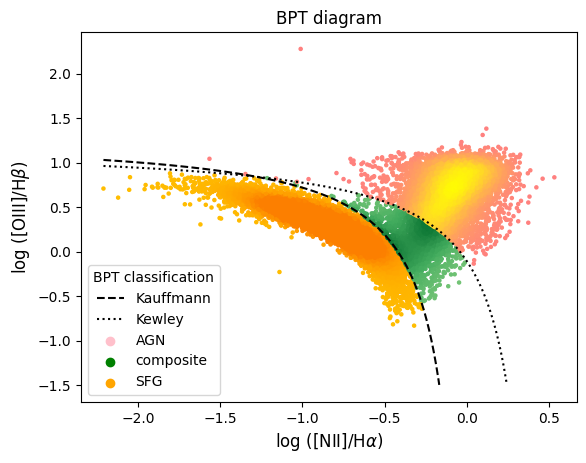

In [317]:
# corresponding BPT

fig = bpt_plt(bpt_classifier(gal_sub))
fig.savefig('tbt_bpt.pdf', dpi=100);

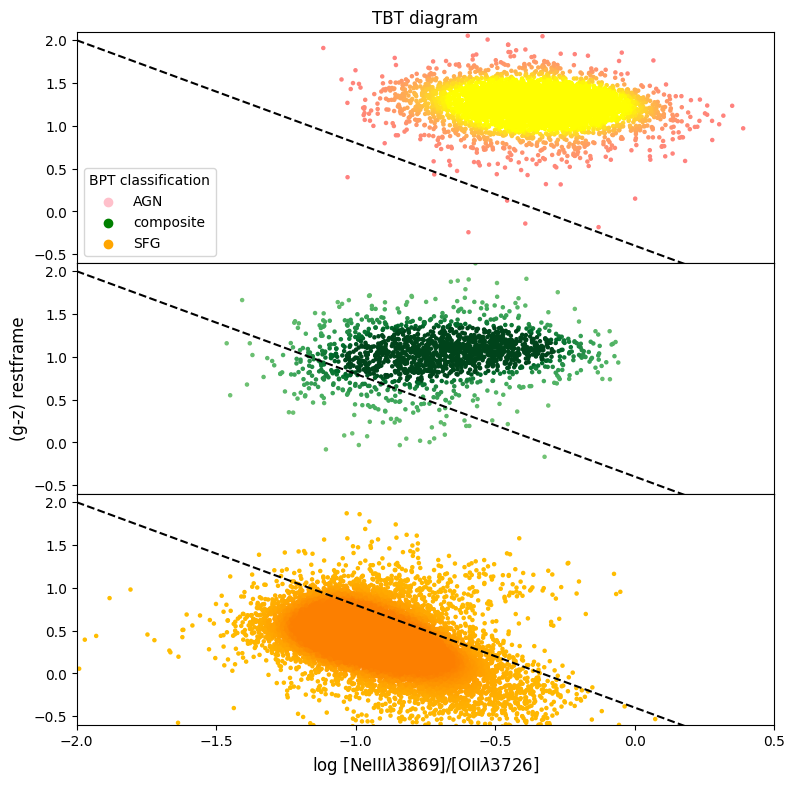

In [318]:
# TBT diagram

df = gal_sub

fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(9,9), gridspec_kw=dict(height_ratios=[1, 1, 1]))


class_dict = {'SFG': plt.cm.Wistia,
              'composite': plt.cm.Greens, 
              'AGN': plt.cm.spring
              }

def kde_plot(ax, df, class_gal):
    df_sub = df[df['class_BPT']==class_gal]
    x = df_sub['x_TBT']
    y = df_sub['(g-z)_kcor']
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    normalize = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    ax.scatter(x, y, c=z, s=5, edgecolor=None, 
               cmap=class_dict[class_gal], norm=normalize, label=class_gal)

for ax, class_gal in zip(axs, list(class_dict.keys())[::-1]):
    kde_plot(ax, df, class_gal)
    x = np.linspace(-2, 0.5, 1000)
    y = -1.2*x - 0.4
    ax.plot(x, y, 'k--')
    ax.set_ylim(-0.6, 2.1)
    ax.set_xlim(-2, 0.5)

yticks = axs[2].yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)

scatter1 = plt.scatter([], [], c='#FFA500', label="SFG")
scatter2 = plt.scatter([], [], c='green', label="composite")
scatter3 = plt.scatter([], [], c='#FFC0CB', label="AGN")
axs[0].set_title('TBT diagram')
axs[0].legend((scatter3, scatter2, scatter1), ["AGN", "composite", "SFG"], loc='lower left', title='BPT classification', fontsize='medium')
axs[1].set_ylabel("(g-z) restframe", fontsize=12)
plt.xlabel(r"log [NeIII$\lambda$3869]/[OII$\lambda$3726]", fontsize=12)
plt.subplots_adjust(hspace=.0)
plt.savefig('tbt.pdf', dpi=100);

In [319]:
# TBT classifier

gal_sub['class_TBT'] = np.where(((gal_sub['(g-z)_kcor']) > (-1.2*gal_sub['x_TBT']-0.1)), 'AGN', 'other')

print(f"AGN in BPT: {gal_sub[(gal_sub.class_BPT =='AGN')].count()[0]/len(gal_sub) * 100} %"
      f"\nAGN in TBT: {gal_sub[(gal_sub.class_TBT =='AGN')].count()[0]/len(gal_sub) * 100}%"
      f"\nAGN in BPT and TBT: {gal_sub[(gal_sub.class_BPT =='AGN') & (gal_sub.class_TBT =='AGN')].count()[0]/len(gal_sub) * 100} %")

AGN in BPT: 26.498966230186078 %
AGN in TBT: 34.3605395293886%
AGN in BPT and TBT: 26.385743821994684 %


## Task 3

For sample of AGN selected from the SDSS database, find the WISE counterparts with a matching tolerance of 3ʹʹ (∼ 0.5×FWHM of the WISE PSF at 3.4 μm), and get the three WISE colors (W1,W2,W3). Locate the object on the WISE colour-colour plot using the selection criteria defined by Mateos et al. (2012, 2013):

$y = 0.315 \times x$

x = log10(f12um/f4.6um)

y = log10(f4.6um/f3.4um)

The top and bottom boundaries of the wedge are obtained by adding y-axis intercepts of +0.297 and −0.110, respectively. The MIR power-law $\alpha$=−0.3 bottom-left limit corresponds to:

$y = -3.172 \times x + 0.436$

Plot your results on top of the Figure 12 taken from Wright et al. (2010).

Comment on what is the percentage of object found in both SDSS and WISE survey, what is the number/percentage of objects defined as AGN by SDSS and WISE, as well as what is the number/percentage of objects found to be AGN by both surveys.

In [320]:
# sdss query through astropy

with open('query3.txt', 'r') as file:
    query = file.read().replace('\n', ' ') ## input is a single string

results_cross = SDSS.query_sql(query, timeout=500, data_release=18).to_pandas()

results_cross.to_csv('nlr_cross.csv', sep=',')

In [321]:
# our data

gal_mir = pd.read_csv('nlr_cross.csv', sep=',', index_col=0)
gal_mir = pd.merge(gal_mir, gal, on=['plate', 'mjd', 'fiberid'])
gal_mir = bpt_classifier(gal_mir)
gal_mir.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25283 entries, 0 to 25282
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   plate            25283 non-null  int64  
 1   mjd              25283 non-null  int64  
 2   fiberid          25283 non-null  int64  
 3   z_x              25283 non-null  float64
 4   subclass_x       24560 non-null  object 
 5   e_bv_sfd         25283 non-null  float64
 6   w1mpro           25283 non-null  float64
 7   w2mpro           25283 non-null  float64
 8   w3mpro           25283 non-null  float64
 9   w1flux           25283 non-null  float64
 10  w2flux           25283 non-null  float64
 11  w3flux           25283 non-null  float64
 12  class            25283 non-null  object 
 13  subclass_y       24560 non-null  object 
 14  z_y              25283 non-null  float64
 15  h_alpha_flux     25283 non-null  float64
 16  h_beta_flux      25283 non-null  float64
 17  oiii_5007_fl

In [322]:
gal_mir

,plate,mjd,fiberid,z_x,subclass_x,e_bv_sfd,w1mpro,w2mpro,w3mpro,w1flux,...,class_Kewley,class_BPT,kde,class_Kewley_si,class_Kewley_oi,y_WHAN,z_WHAN,group_WHAN,subclass_WHAN,class_WHAN
0,415,51879,260,0.022035,STARFORMING,0.127694,14.544,14.465,10.891,241.26,...,SFG,SFG,0.120566,SFG,SFG,13.73114,3.423143,ELG,SFG,SFG
1,415,51810,360,0.085868,AGN,0.126359,13.947,13.039,9.897,418.18,...,QSO,AGN,0.474262,QSO,QSO,11.33642,5.082558,ELG,Seyfert,AGN
2,416,51885,210,0.036202,STARFORMING,0.110560,14.217,14.076,10.410,326.07,...,SFG,SFG,3.564046,SFG,SFG,36.17113,10.258080,ELG,SFG,SFG
3,416,51811,415,0.040687,STARFORMING,0.090598,12.834,12.588,8.793,1165.60,...,SFG,composite,0.878044,SFG,SFG,14.82782,7.739981,ELG,Seyfert,AGN
4,416,51885,535,0.192938,STARFORMING,0.122702,13.808,12.995,9.496,475.09,...,SFG,SFG,1.959903,SFG,SFG,36.32200,14.752560,ELG,Seyfert,AGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25278,637,52174,565,0.051517,STARFORMING,0.093252,14.740,14.513,11.088,201.37,...,SFG,SFG,2.290703,SFG,SFG,31.45983,7.826671,ELG,SFG,SFG
25279,637,52174,632,0.058183,STARBURST,0.088734,14.565,14.513,10.525,236.67,...,SFG,SFG,4.097437,SFG,SFG,43.18356,14.681720,ELG,SFG,SFG
25280,638,52081,64,0.123862,STARBURST,0.160830,15.278,14.924,10.591,122.70,...,SFG,SFG,1.987927,SFG,SFG,58.53621,15.357580,ELG,SFG,SFG
25281,640,52178,137,0.095698,STARFORMING,0.091285,14.696,14.592,10.883,209.70,...,SFG,SFG,2.579197,SFG,SFG,23.35010,7.561523,ELG,SFG,SFG


In [323]:
# extinction correction

R_w1w2 = 0.056 ## source: https://arxiv.org/abs/2210.15918
R_w2w3 = -0.045

gal_mir['w1-w2'] = gal_mir['w1mpro'] - gal_mir['w2mpro'] - (R_w1w2 * gal_mir['e_bv_sfd'])
gal_mir['w2-w3'] = gal_mir['w2mpro'] - gal_mir['w3mpro'] - (R_w2w3 * gal_mir['e_bv_sfd'])

gal_mir['x_mat'] = np.log10(gal_mir['w3flux']/gal_mir['w2flux'])
gal_mir['y_mat'] = np.log10(gal_mir['w2flux']/gal_mir['w1flux'])

In [324]:
# WISE classification

gal_mir['class_WISE'] = np.where((gal_mir['w1-w2'] >= 0.8), 'AGN', 
                                 (np.where((gal_mir['w2-w3'] <= 2), 'Spheroids', 
                                           (np.where(((gal_mir['w2-w3'] <= 3.5) & (gal_mir['w2-w3'] > 2)), 'Intermediate disks', 
                                                     (np.where((gal_mir['w2-w3'] > 3.5), 'SF disks', '')))))))

In [331]:
gal_mir

,plate,mjd,fiberid,z_x,subclass_x,e_bv_sfd,w1mpro,w2mpro,w3mpro,w1flux,...,y_WHAN,z_WHAN,group_WHAN,subclass_WHAN,class_WHAN,w1-w2,w2-w3,x_mat,y_mat,class_WISE
0,415,51879,260,0.022035,STARFORMING,0.127694,14.544,14.465,10.891,241.26,...,13.73114,3.423143,ELG,SFG,SFG,0.071849,3.579746,0.829575,-0.368553,SF disks
1,415,51810,360,0.085868,AGN,0.126359,13.947,13.039,9.897,418.18,...,11.33642,5.082558,ELG,Seyfert,AGN,0.900924,3.147686,0.656830,-0.036896,AGN
2,416,51885,210,0.036202,STARFORMING,0.110560,14.217,14.076,10.410,326.07,...,36.17113,10.258080,ELG,SFG,SFG,0.134809,3.670975,0.866302,-0.343783,SF disks
3,416,51811,415,0.040687,STARFORMING,0.090598,12.834,12.588,8.793,1165.60,...,14.82782,7.739981,ELG,Seyfert,AGN,0.240927,3.799077,0.918252,-0.301836,SF disks
4,416,51885,535,0.192938,STARFORMING,0.122702,13.808,12.995,9.496,475.09,...,36.32200,14.752560,ELG,Seyfert,AGN,0.806129,3.504522,0.799353,-0.074607,AGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25278,637,52174,565,0.051517,STARFORMING,0.093252,14.740,14.513,11.088,201.37,...,31.45983,7.826671,ELG,SFG,SFG,0.221778,3.429196,0.770122,-0.309216,Intermediate disks
25279,637,52174,632,0.058183,STARBURST,0.088734,14.565,14.513,10.525,236.67,...,43.18356,14.681720,ELG,SFG,SFG,0.047031,3.991993,0.995416,-0.379501,SF disks
25280,638,52081,64,0.123862,STARBURST,0.160830,15.278,14.924,10.591,122.70,...,58.53621,15.357580,ELG,SFG,SFG,0.344994,4.340237,1.133382,-0.258429,SF disks
25281,640,52178,137,0.095698,STARFORMING,0.091285,14.696,14.592,10.883,209.70,...,23.35010,7.561523,ELG,SFG,SFG,0.098888,3.713108,0.883920,-0.358538,SF disks


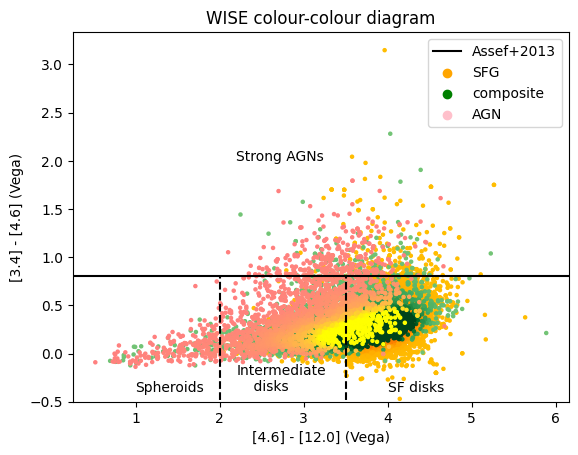

In [325]:
# WISE colour-colour plot

df = gal_mir
x = df['w2-w3']
y = df['w1-w2']
xy = np.vstack([x,y])
df['kde'] = gaussian_kde(xy)(xy)

class_dict = {'SFG': plt.cm.Wistia, 
              'composite': plt.cm.Greens, 
              'AGN': plt.cm.spring
              }
    
for class_gal in class_dict.keys():
    df_sub = df[df['class_BPT'] == class_gal]
    x_sub = df_sub['w2-w3']
    y_sub = df_sub['w1-w2']
    z_sub = df_sub["kde"]
    normalize = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    plt.scatter(x_sub, y_sub, c=z_sub, s=5, edgecolor=None,
                cmap=class_dict[class_gal], norm=normalize)

scatter1 = plt.scatter([], [], c='#FFA500', label="SFG")
scatter2 = plt.scatter([], [], c='green', label="composite")
scatter3 = plt.scatter([], [], c='#FFC0CB', label="AGN")
plt.legend((scatter3, scatter2, scatter1), ["QSO", "composite", "SFG"], 
            loc='upper left', title="BPT classification", fontsize='medium')

plt.axhline(y=0.8, c='k', label="Assef+2013")
plt.vlines(x=2, ymin=-0.6, ymax=0.8, colors='k', linestyle='--')
plt.vlines(x=3.5, ymin=-0.6, ymax=0.8, colors='k', linestyle='--')
plt.annotate('Strong AGNs', xy=(2.2,2), color='black')
plt.annotate('Spheroids', xy=(1,-0.4), color='black')
plt.annotate('Intermediate\n    disks', xy=(2.2,-0.39), color='black')
plt.annotate('SF disks', xy=(4,-0.4), color='black')
plt.ylim(bottom=-0.5)

plt.xlabel("[4.6] - [12.0] (Vega)")
plt.ylabel("[3.4] - [4.6] (Vega)")
plt.title("WISE colour-colour diagram")

plt.legend()
plt.savefig('wise_cc.pdf', dpi=100);

In [354]:
# WHAN classification
x_top = (7.624-0.796)/(0.315+3.172)
x_bot = (7.624+0.222)/(0.315+3.172)

def y_top(x): return 0.315*x+0.796 if x>=x_top else -np.inf
def y_bot(x): return 0.315*x-0.222 if x>=x_bot else -np.inf
def y_lim(x): return -3.172*x+7.624 if x>=x_top and x<=x_bot else -np.inf

for i, x, y in zip(gal_mir.index, gal_mir['w2-w3'], gal_mir['w1-w2']):
    if y <= y_top(x) and y > y_lim(x) and y > y_bot(x):
        gal_mir.loc[i, 'class_Mateos'] = "AGN"
    else:
        gal_mir.loc[i, 'class_Mateos'] = "other"
        
gal_mir['class_Mateos'].value_counts()

other    24828
AGN        455
Name: class_Mateos, dtype: int64

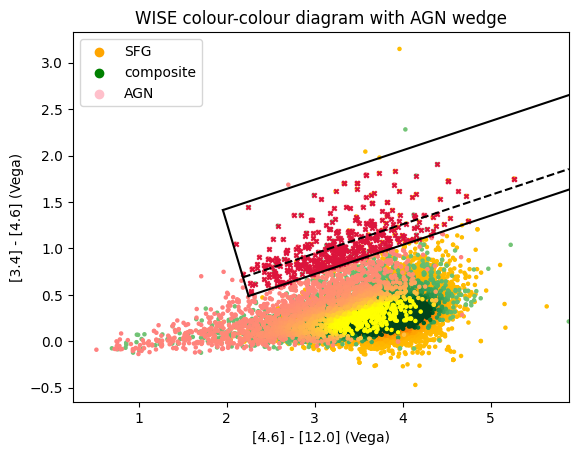

In [358]:
# c-c plot with AGN wedge Matteos+2012 checking classification is right

df = gal_mir
x = df['w2-w3']
y = df['w1-w2']
xy = np.vstack([x,y])
df['kde'] = gaussian_kde(xy)(xy)

class_dict = {'SFG': plt.cm.Wistia, 
              'composite': plt.cm.Greens, 
              'AGN': plt.cm.spring
              }
    
for class_gal in class_dict.keys():
    df_sub = df[df['class_BPT'] == class_gal]
    x_sub = df_sub['w2-w3']
    y_sub = df_sub['w1-w2']
    z_sub = df_sub['kde']
    normalize = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    plt.scatter(x_sub, y_sub, c=z_sub, s=5, edgecolor=None,
                cmap=class_dict[class_gal], norm=normalize)

df_sub = df[df['class_Mateos'] == 'AGN']
plt.scatter(df_sub['w2-w3'], df_sub['w1-w2'],  color='crimson', marker='x', s=10, zorder=1)

scatter1 = plt.scatter([], [], c='#FFA500', label="SFG")
scatter2 = plt.scatter([], [], c='green', label="composite")
scatter3 = plt.scatter([], [], c='#FFC0CB', label="AGN")
plt.legend((scatter3, scatter2, scatter1), ["QSO", "composite", "SFG"], 
            loc='upper left', title="BPT classification", fontsize='medium')


def y_cen(x): return [0.315*i for i in x]
def y_top(x): return [0.315*i+0.796 for i in x]
def y_bot(x): return [0.315*i-0.222 for i in x]
def y_lim(x): return [-3.172*i+7.624 for i in x]

x_cen = (7.624)/(0.315+3.172)
x_top = (7.624-0.796)/(0.315+3.172)
x_bot = (7.624+0.222)/(0.315+3.172)
def x_range(x_pos): return np.linspace(x_pos, np.max(df['w2-w3']), 100)
x_lim = np.linspace(x_top, x_bot, 100)

plt.plot(x_range(x_cen), y_cen(x_range(x_cen)), 'k--')
plt.plot(x_range(x_top), y_top(x_range(x_top)), 'k-')
plt.plot(x_range(x_bot), y_bot(x_range(x_bot)), 'k-')
plt.plot(x_lim, y_lim(x_lim), 'k-')
plt.xlim(right=np.max(df['w2-w3']))

plt.legend()
plt.xlabel("[4.6] - [12.0] (Vega)")
plt.ylabel("[3.4] - [4.6] (Vega)")
plt.title("WISE colour-colour diagram with AGN wedge");

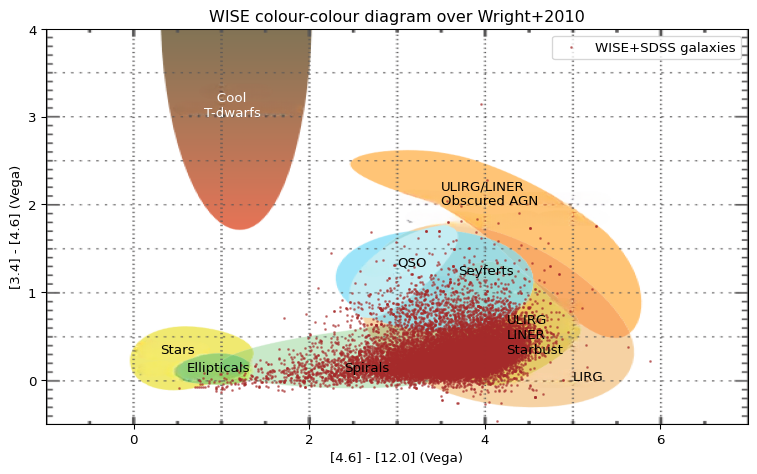

In [326]:
# c-c plot over Wright+2010

fig = plt.figure(figsize=(566*2/120, 622*2/120), dpi=96)

img = plt.imread('wright+2010_cleanup.png')
plt.imshow(img, zorder=0, extent=[-1.009, 7, -0.510, 4], alpha=0.75, aspect='equal')

plt.scatter(gal_mir['w2-w3'], gal_mir['w1-w2'],  color='brown', marker='.', alpha=0.5, s=5, zorder=1, label='WISE+SDSS galaxies')
plt.annotate('   Cool\nT-dwarfs', xy=(0.8,3), color='white')
plt.annotate('Ellipticals', xy=(0.6,0.1), color='black')
plt.annotate('Stars', xy=(0.3,0.3), color='black')
plt.annotate('Spirals', xy=(2.4,0.1), color='black')
plt.annotate('QSO', xy=(3,1.3), color='black')
plt.annotate('Seyferts', xy=(3.7,1.2), color='black')
plt.annotate('ULIRG\nLINER\nStarbust', xy=(4.25,0.3), color='black')
plt.annotate('LIRG', xy=(5,0), color='black')
plt.annotate('ULIRG/LINER\nObscured AGN', xy=(3.5,2), color='black')

plt.xlim(-1,7)
plt.xticks(np.arange(0, 7, 2))
plt.yticks(np.arange(0, 5, 1))
plt.ylim(-0.5,4)

plt.xlabel("[4.6] - [12.0] (Vega)")
plt.ylabel("[3.4] - [4.6] (Vega)")
plt.title("WISE colour-colour diagram over Wright+2010")

plt.legend()
plt.savefig('wise_wright+2010.pdf', dpi=100);

In [346]:
gal_mir['subclass_x'].value_counts()

STARFORMING              12471
STARBURST                 9866
AGN                       1804
AGN BROADLINE              197
BROADLINE                   95
STARBURST BROADLINE         87
STARFORMING BROADLINE       40
Name: subclass_x, dtype: int64

In [332]:
gal_mir['class_WISE'].value_counts()

SF disks              18363
Intermediate disks     5979
AGN                     659
Spheroids               282
Name: class_WISE, dtype: int64

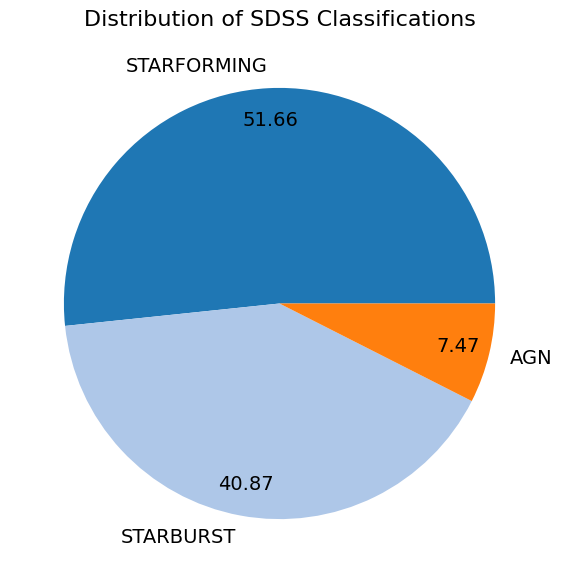

In [336]:
# Count the occurrences of each subclass in the SDSS data
SDSS_counts = gal_mir['subclass_x'].value_counts()

# Define a threshold for negligible categories (e.g., less than 1% of the total)
threshold = 0.01 * SDSS_counts.sum()

# Filter out negligible categories
SDSS_counts = SDSS_counts[SDSS_counts >= threshold]

# Define colors (optional, can be adjusted for colorblind-friendly palettes)
colorblind_palette = sns.color_palette("colorblind", len(SDSS_counts))

# Plot the pie chart using the matplotlib pie function
plt.figure(figsize=(7, 7))
plt.pie(SDSS_counts, autopct='%.2f', 
        textprops={'fontsize': 14}, 
        colors=colors, labels=SDSS_counts.index,
        pctdistance=0.85, labeldistance=1.1)

plt.title('Distribution of SDSS Classifications', fontsize=16)
plt.show()


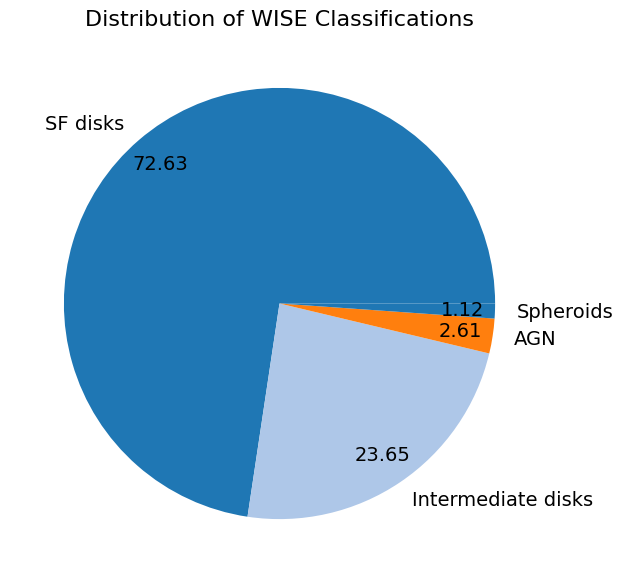

In [338]:
# Count the occurrences of each subclass in the WISE data
WISE_counts = gal_mir['class_WISE'].value_counts()

# Define a threshold for negligible categories (e.g., less than 1% of the total)
threshold = 0.01 * WISE_counts.sum()

# Filter out negligible categories
WISE_counts = WISE_counts[WISE_counts >= threshold]

# Define colors (optional, can be adjusted for colorblind-friendly palettes)
colorblind_palette = sns.color_palette("colorblind", len(WISE_counts))

# Plot the pie chart using the matplotlib pie function
plt.figure(figsize=(7, 7))
plt.pie(WISE_counts, autopct='%.2f', 
        textprops={'fontsize': 14}, 
        colors=colors, labels=WISE_counts.index,
        pctdistance=0.85, labeldistance=1.1)

plt.title('Distribution of WISE Classifications', fontsize=16)
plt.show()

In [344]:
# Filter the DataFrame to get only AGNs in both WISE and SDSS
agn_both = gal_mir[(gal_mir['class_WISE'] == 'AGN') & (gal_mir['subclass_x'] == 'AGN')]

# Calculate the number of AGNs in both WISE and SDSS
num_agn_both = len(agn_both)

# Calculate the total number of objects in the DataFrame
total_objects = len(df)

# Calculate the percentage of AGNs in both WISE and SDSS
percentage_agn_both = (num_agn_both / total_objects) * 100

print(f"Number of AGNs in both WISE and SDSS: {num_agn_both}")
print(f"Percentage of AGNs in both WISE and SDSS: {percentage_agn_both:.2f}%")

Number of AGNs in both WISE and SDSS: 205
Percentage of AGNs in both WISE and SDSS: 0.81%


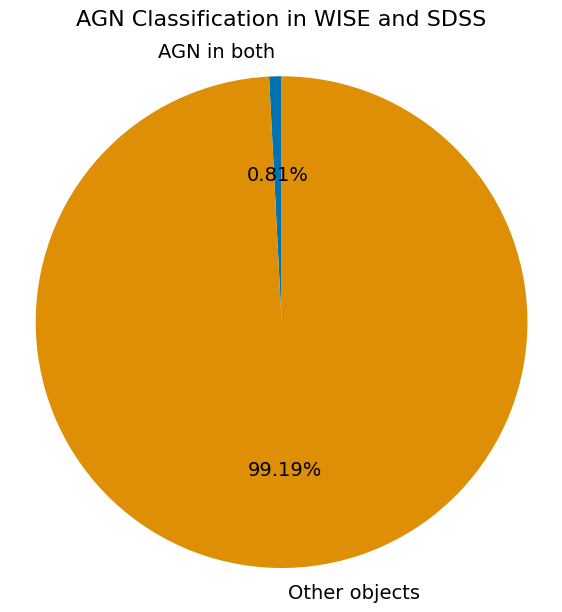

In [352]:
# Calculate the number of non-AGNs in both WISE and SDSS
num_non_agn_both = total_objects - num_agn_both

# Create a DataFrame for the pie chart
labels = ['AGN in both', 'Other objects']
sizes = [num_agn_both, num_non_agn_both]

# Define a colorblind-friendly palette using seaborn
colorblind_palette = sns.color_palette("colorblind", len(sizes))

# Plot the pie chart using the matplotlib pie function
plt.figure(figsize=(7, 7))
plt.pie(sizes, autopct='%.2f%%', startangle=90,
        colors=colorblind_palette, labels=labels,
        textprops={'fontsize': 14})

plt.title('AGN Classification in WISE and SDSS', fontsize=16, pad=20)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


## Task 4

From a catalogue of SDSS Stripe82 variable sources select a sample (at least 10) of quasar (type 1 AGN) light curve and test the QNPy package, for quasar light curves modeling using Conditional Neural Processes (follow tutorial without clustering, _tip: check the demo workshop from SER-SAG-S1)_. For each light curve provides a basic info-sheet with: number of points, number of gaps (think of a metric to identify gaps), mean and median sampling, maximal/minimal/mean/median magnitude, variability amplitude. Comment on how well the QNPy models the light curve based on the above listed light curve parameters.

In [1]:
import QNPy #Importing the package

from QNPy import Preprocess as pr #Importing Preprocess module from the package
from QNPy.Preprocess import transform #importing the funcion transform for transformation the data
from QNPy.Preprocess import * #importing all external packages from Preprocess
import pandas as pd

In [3]:
#Importing the data. This can be done in any desired manner, but the data must contain:
#mjd - MJD or time, mag-magnitude and magerr-magnitude error. 
# In this example we used pandas python package for importing the .csv data, but numpy can be used if the data is 
#in .txt file
path = './light_curves' #path to data
csv_files = glob.glob(path + "/*.csv")
df_list = (pd.read_csv(file) for file in csv_files)
data = pd.concat(df_list, ignore_index=True)

In [5]:
# Padding the light curves
# We added the function for backward padding the curves with last observed value
# The length for padding should remain 100 or above 
# If you previously remowed the outliers from your light curves and saved the new one 
#in the folder light_curves_clean, here you use this folder insted of "./light_curves"

padding= pr.backward_pad_curves('./light_curves_clean', './Padded_lc', desired_observations=100)

Created new file: ./Padded_lc/3152786.csv
Created new file: ./Padded_lc/LC_891556.csv
Created new file: ./Padded_lc/2524327.csv
Created new file: ./Padded_lc/3102202.csv
Created new file: ./Padded_lc/3104329.csv
Created new file: ./Padded_lc/3097526.csv
Created new file: ./Padded_lc/LC_942750.csv
Created new file: ./Padded_lc/2473812.csv
Created new file: ./Padded_lc/LC_885742.csv
Created new file: ./Padded_lc/LC_960085.csv
Created new file: ./Padded_lc/LC_905376.csv
Created new file: ./Padded_lc/3844725.csv
Created new file: ./Padded_lc/3078106.csv
Created new file: ./Padded_lc/3032591.csv
Created new file: ./Padded_lc/LC_897228.csv
Created new file: ./Padded_lc/LC_962398.csv
Created new file: ./Padded_lc/2579983.csv
Created new file: ./Padded_lc/LC_999886.csv
Created new file: ./Padded_lc/LC_910866.csv
Created new file: ./Padded_lc/LC_929605.csv


In [4]:
#Cleaning the outliers second approach
#This function not only cleans data by removing outliers but also aggregates time and fluxes, 
#computing a weighted average of magnitudes for closely spaced time points, 
#and then saves the cleaned and aggregated files.

input_folder = './light_curves'
output_folder = './light_curves_clean'
threshold_aggregation = 5
threshold_outliers = 3.0

outliers=pr.clean_save_aggregate_data(input_folder, output_folder, threshold_aggregation, threshold_outliers)

Cleaned and saved 3152786.csv to ./light_curves_clean/3152786.csv
Cleaned and saved 2524327.csv to ./light_curves_clean/2524327.csv
Cleaned and saved 3102202.csv to ./light_curves_clean/3102202.csv
Cleaned and saved 3104329.csv to ./light_curves_clean/3104329.csv
Cleaned and saved 3097526.csv to ./light_curves_clean/3097526.csv
Cleaned and saved 2473812.csv to ./light_curves_clean/2473812.csv
Cleaned and saved 3844725.csv to ./light_curves_clean/3844725.csv
Cleaned and saved 3078106.csv to ./light_curves_clean/3078106.csv
Cleaned and saved 3032591.csv to ./light_curves_clean/3032591.csv
Cleaned and saved 2579983.csv to ./light_curves_clean/2579983.csv
Processing completed.


Text(0, 0.5, 'Magnitude')

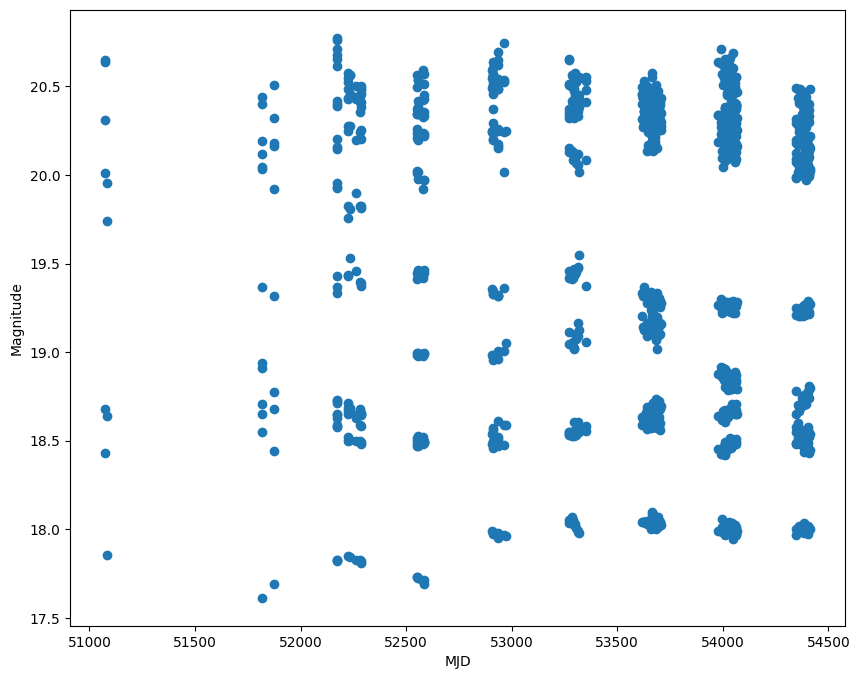

In [10]:
plt.figure(figsize=(10,8))

plt.scatter(data['mjd'], data['mag'])
plt.xlabel('MJD')
plt.ylabel('Magnitude')

In [6]:
#Path to Padded Data
DATA_SRC = "./Padded_lc" 
#path to folder to save preproc data (transformed data) + errors
DATA_DST = "./preproc" 

In [7]:
#listing the data that are going to be transformed. 
#In case that your original data is in one table, this is not needed
files = os.listdir(DATA_SRC) 

In [9]:
#running the transformation function
number_of_points, trcoeff = pr.transform_and_save(files, DATA_SRC, DATA_DST, transform)

warning found: invalid value encountered in divide
LC_891556
warning found: invalid value encountered in divide
LC_942750
warning found: invalid value encountered in divide
LC_885742
warning found: invalid value encountered in divide
LC_960085
warning found: invalid value encountered in divide
LC_905376
warning found: invalid value encountered in divide
LC_897228
warning found: invalid value encountered in divide
LC_962398
warning found: invalid value encountered in divide
LC_999886
warning found: invalid value encountered in divide
LC_910866
warning found: invalid value encountered in divide
LC_929605


In [1]:
import QNPy #Importing the package
from QNPy import SPLITTING_AND_TRAINING as st #Importing SPLITTING_AND_TRAINING module from the package
from QNPy.SPLITTING_AND_TRAINING import * #Importing all packages from SPLITTING_AND_TRAINING module

In [2]:
DATA_SRC = "./preproc" #Path to transformed data

In [3]:
files = os.listdir(DATA_SRC) #listing the transformed data

In [4]:
#creating the folders for saving the splitted data
st.create_split_folders(train_folder='./dataset/train/', test_folder='./dataset/test/', val_folder='./dataset/val/')

In [5]:
#path to TRAIN, TEST and VAL folders where your splitted data will be saved. 
#You can directly enter this informations in split_data function
TRAIN_FOLDER = './dataset/train/'
TEST_FOLDER = './dataset/test/'
VAL_FOLDER = './dataset/val/'

In [6]:
#running the function for splitting the data
st.split_data(files, DATA_SRC, TRAIN_FOLDER, TEST_FOLDER, VAL_FOLDER) 

100%|███████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 404.82it/s]


In [7]:
DATA_PATH_TRAIN = "./dataset/train" #path to train folder
DATA_PATH_VAL = "./dataset/val" #path to val folder

MODEL_PATH = "./output/cnp_model.pth" #path for saving model

In [8]:
BATCH_SIZE=32 #Defining the batch size, it should remain 32

In [9]:
#running the function for getting the data loaders of data that are going to be trained
trainLoader, valLoader = st.get_data_loaders(DATA_PATH_TRAIN, DATA_PATH_VAL, BATCH_SIZE) 

In [10]:
#defining the device for testing, it can be CPU of CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device

device(type='cpu')

In [11]:
#runing the function fo creating the model (deterministic model is default) 
#and optimiser (LogProbLoss), mseMetric (MSELoss)
model, optimizer, criterion, mseMetric, maeMetric = st.create_model_and_optimizer(device) 

In [13]:
import warnings
warnings.filterwarnings('ignore')
#function for training the data
# numbers that we give in this example are: 
#1 - number of train_model function runs
#3000 - number of epochs
#2000 - number of early stopping limit
# These numbers are optional and can be changed as needed.
history_loss_train, history_loss_val, \
history_mse_train, history_mse_val, \
history_mae_train, history_mae_val, \
epoch_counter_train_loss, epoch_counter_train_mse, \
epoch_counter_train_mae, epoch_counter_val_loss, \
epoch_counter_val_mse, epoch_counter_val_mae = st.train_model(
    model, trainLoader, valLoader, criterion, optimizer, 1, 1000, 500, mseMetric, maeMetric, device)

100%|████████████████████████████████████████████████████████████████| 1000/1000 [01:07<00:00, 14.87it/s]


In [14]:
# Define the file names for saving the lists for all histories
file_names = ["history_loss_train.csv", "history_loss_val.csv", "history_mse_train.csv", "history_mse_val.csv",
              "history_mae_train.csv", "history_mae_val.csv", "epoch_counter_train_loss.csv",
              "epoch_counter_train_mse.csv", "epoch_counter_train_mae.csv", "epoch_counter_val_loss.csv",
              "epoch_counter_val_mse.csv", "epoch_counter_val_mae.csv"]

# Define the lists
lists = [history_loss_train, history_loss_val, history_mse_train, history_mse_val, history_mae_train,
         history_mae_val, epoch_counter_train_loss, epoch_counter_train_mse, epoch_counter_train_mae,
         epoch_counter_val_loss, epoch_counter_val_mse, epoch_counter_val_mae]

In [15]:
#running the function for saving all lists with histories
save_list= st.save_lists_to_csv(file_names, lists)

In [16]:
# Replace with the path to your history_loss_train CSV file
history_loss_train_file = './history_loss_train.csv'  
# Replace with the path to your history_loss_val CSV file
history_loss_val_file = './history_loss_val.csv'  
# Replace with the path to your epoch_counter_train_loss CSV file
epoch_counter_train_loss_file = './epoch_counter_train_loss.csv'

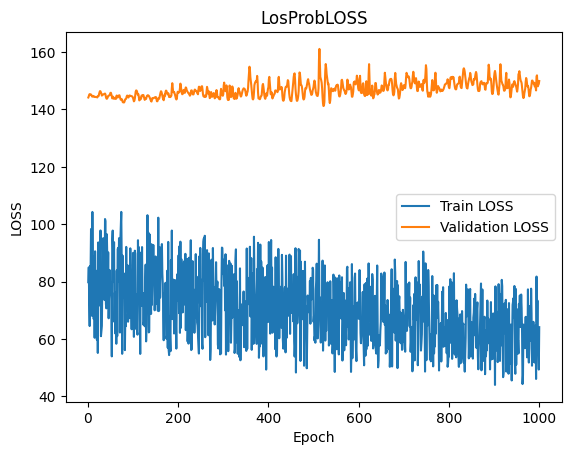

In [17]:
#plotting the Logprobloss after training
logprobloss=st.plot_loss(history_loss_train_file, history_loss_val_file, epoch_counter_train_loss_file)

In [18]:
# Replace with the path to your history_mse_train CSV file
history_mse_train_file = './history_mse_train.csv'
# Replace with the path to your history_mse_val CSV file
history_mse_val_file = './history_mse_val.csv'  
# Replace with the path to your epoch_counter_train_mse CSV file
epoch_counter_train_mse_file = './epoch_counter_train_mse.csv' 

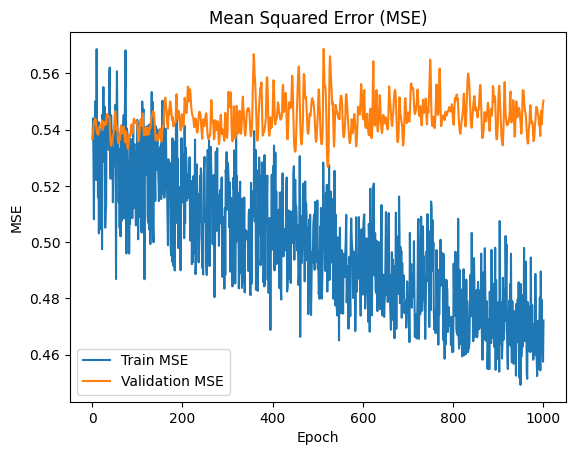

In [19]:
#plotting the MSE metric after training
msemetric=st.plot_mse(history_mse_train_file, history_mse_val_file, epoch_counter_train_mse_file)

In [20]:
# Replace with the path to your history_mae_train CSV file
history_mae_train_file = './history_mae_train.csv'
# Replace with the path to your history_mae_val CSV file
history_mae_val_file = './history_mae_val.csv'  
# Replace with the path to your epoch_counter_train_mae CSV file
epoch_counter_train_mae_file = './epoch_counter_train_mae.csv'  

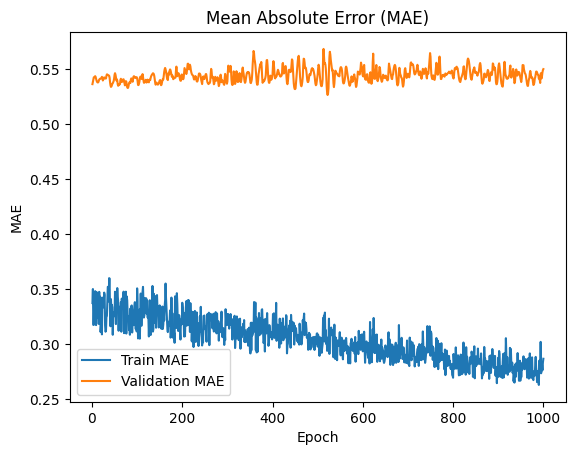

In [21]:
#plotting the MAE metric after training
maemetric=st.plot_mae(history_mae_train_file, history_mae_val_file, epoch_counter_train_mae_file)

In [23]:
save=st.save_model(model, MODEL_PATH)#saving the trained model

In [24]:
import QNPy #Importing the package
#Importing PREDICTION_onePDF_original_mjd module from the package
from QNPy import PREDICTION_onePDF_original_mjd as pop
#Importing all packages from PREDICTION_onePDF_original_mjd module
from QNPy.PREDICTION_onePDF_original_mjd import * 
#The functions plot_function2, back_x, back_y and find_LC_transorm must be imported separately
from QNPy.PREDICTION_onePDF_original_mjd import plot_function2, back_x, back_y, find_LC_transform 

In [25]:
#defining the device, it can be cpu of cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [26]:
# Creating all needed folders
# If you already manually created prediction folders, this can be scipped
pop.create_prediction_folders()

Created folder: ./output/predictions/train
Created folder: ./output/predictions/train/plots
Created folder: ./output/predictions/train/data
Created folder: ./output/predictions/test
Created folder: ./output/predictions/test/plots
Created folder: ./output/predictions/test/data
Created folder: ./output/predictions/val
Created folder: ./output/predictions/val/plots
Created folder: ./output/predictions/val/data


In [27]:
DATA_PATH_TRAIN = "./dataset/train" #path to train folder
DATA_PATH_VAL = "./dataset/val" #path to val folder
DATA_PATH_TEST="./dataset/test" #path to test folder
OUTPUT_PATH = "./output/predictions/" #path where to save the plots and data

MODEL_PATH = "./output/cnp_model.pth" #path to saved model

In [28]:
clearfolders=pop.clear_output_dir(OUTPUT_PATH)#clearing the output directorium, it can be sciped

In [29]:
model = prmodel = pop.load_model(MODEL_PATH, device)#loading trained modeld.load_trained_model(MODEL_PATH, device) #loading the model

In [30]:
criterion, mseMetric=pop.get_criteria()#loading criterion adn metrics

In [31]:
#deleting the padded values from test set
#deleting the curves that we add with plus and minus errors
#filtering the original curves for plotting


folder_path = "./dataset/test"  # Change this to your dataset folder

pop.remove_padded_values_and_filter(folder_path)

Deleted file with 'minus' or 'plus' in the name: 3844725_minus_split22.csv
Removed padding in file: 2524327_original_split0.csv
Deleted file with 'minus' or 'plus' in the name: 3844725_plus_split18.csv


In [32]:
#deleting the padded values from train set
#deleting the curves that we add with plus and minus errors
#filtering the original curves for plotting


folder_path = "./dataset/train"  # Change this to your dataset folder

pop.remove_padded_values_and_filter(folder_path)

Deleted file with 'minus' or 'plus' in the name: 2473812_plus_split23.csv
Deleted file with 'minus' or 'plus' in the name: 3104329_plus_split26.csv
Removed padding in file: 3102202_original_split3.csv
Deleted file with 'minus' or 'plus' in the name: 3104329_minus_split5.csv
Removed padding in file: 3032591_original_split15.csv
Deleted file with 'minus' or 'plus' in the name: 3097526_plus_split24.csv
Deleted file with 'minus' or 'plus' in the name: 2473812_minus_split1.csv
Removed padding in file: 3097526_original_split9.csv
Removed padding in file: 3152786_original_split13.csv
Removed padding in file: 3078106_original_split20.csv
Deleted file with 'minus' or 'plus' in the name: 3032591_plus_split21.csv
Removed padding in file: 2579983_original_split11.csv
Deleted file with 'minus' or 'plus' in the name: 3102202_minus_split25.csv
Removed padding in file: 2473812_original_split27.csv
Removed padding in file: 3844725_original_split7.csv
Deleted file with 'minus' or 'plus' in the name: 303

In [33]:
#deleting the padded values from val set
#deleting the curves that we add with plus and minus errors
#filtering the original curves for plotting


folder_path = "./dataset/val"  # Change this to your dataset folder

pop.remove_padded_values_and_filter(folder_path)

Deleted file with 'minus' or 'plus' in the name: 3152786_minus_split17.csv
Deleted file with 'minus' or 'plus' in the name: 2524327_plus_split29.csv
Deleted file with 'minus' or 'plus' in the name: 3078106_minus_split16.csv
Deleted file with 'minus' or 'plus' in the name: 3102202_plus_split19.csv
Deleted file with 'minus' or 'plus' in the name: 3097526_minus_split10.csv
Removed padding in file: 3104329_original_split28.csv


In [34]:
tr=pop.load_trcoeff()#loading the transformation coeff

In [35]:
testSet, testLoader=pop.load_test_data(DATA_PATH_TEST)#loading test data

In [36]:
trainSet, trainLoader=pop.load_train_data(DATA_PATH_TRAIN)#loading train data

In [37]:
valSet, valLoader = pop.load_val_data(DATA_PATH_VAL)#loading validation data

100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

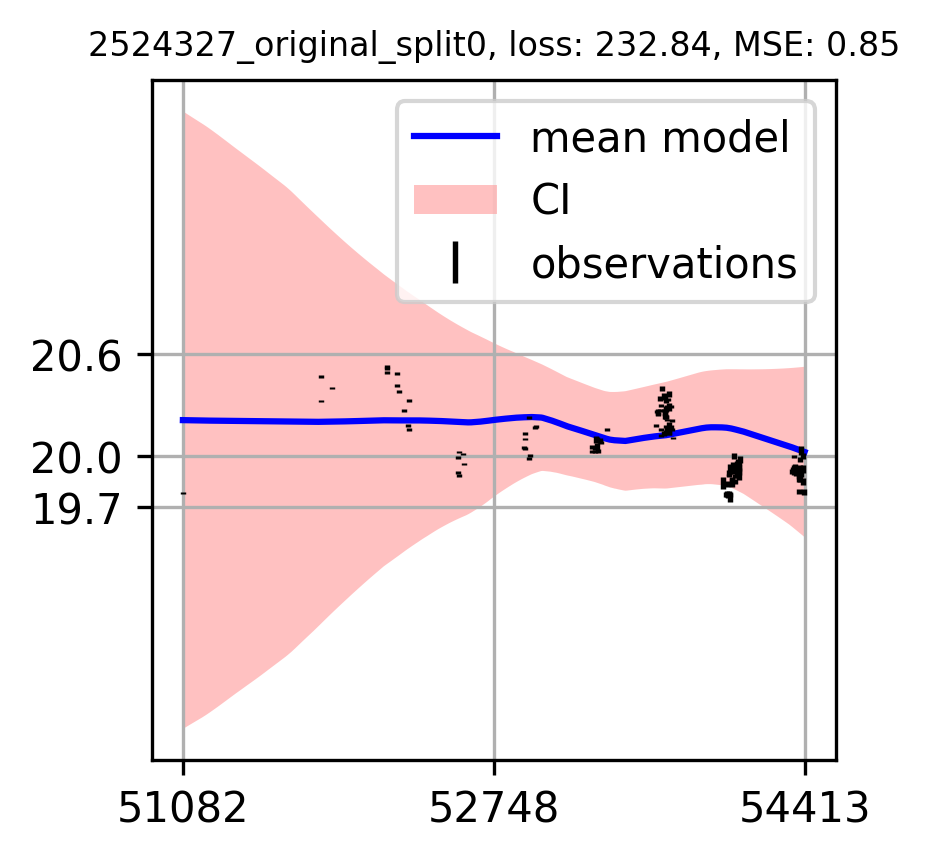

In [38]:
#prediction and plotting od test data
testMetrics=pop.plot_test_light_curves(model, testLoader, criterion, mseMetric, plot_function2, device,tr)

In [39]:
savetest=pop.save_test_metrics(OUTPUT_PATH, testMetrics)#saving the test metrics

 75%|████████████████████████████████████████████████████▌                 | 6/8 [00:00<00:00, 29.09it/s]

100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 29.68it/s]


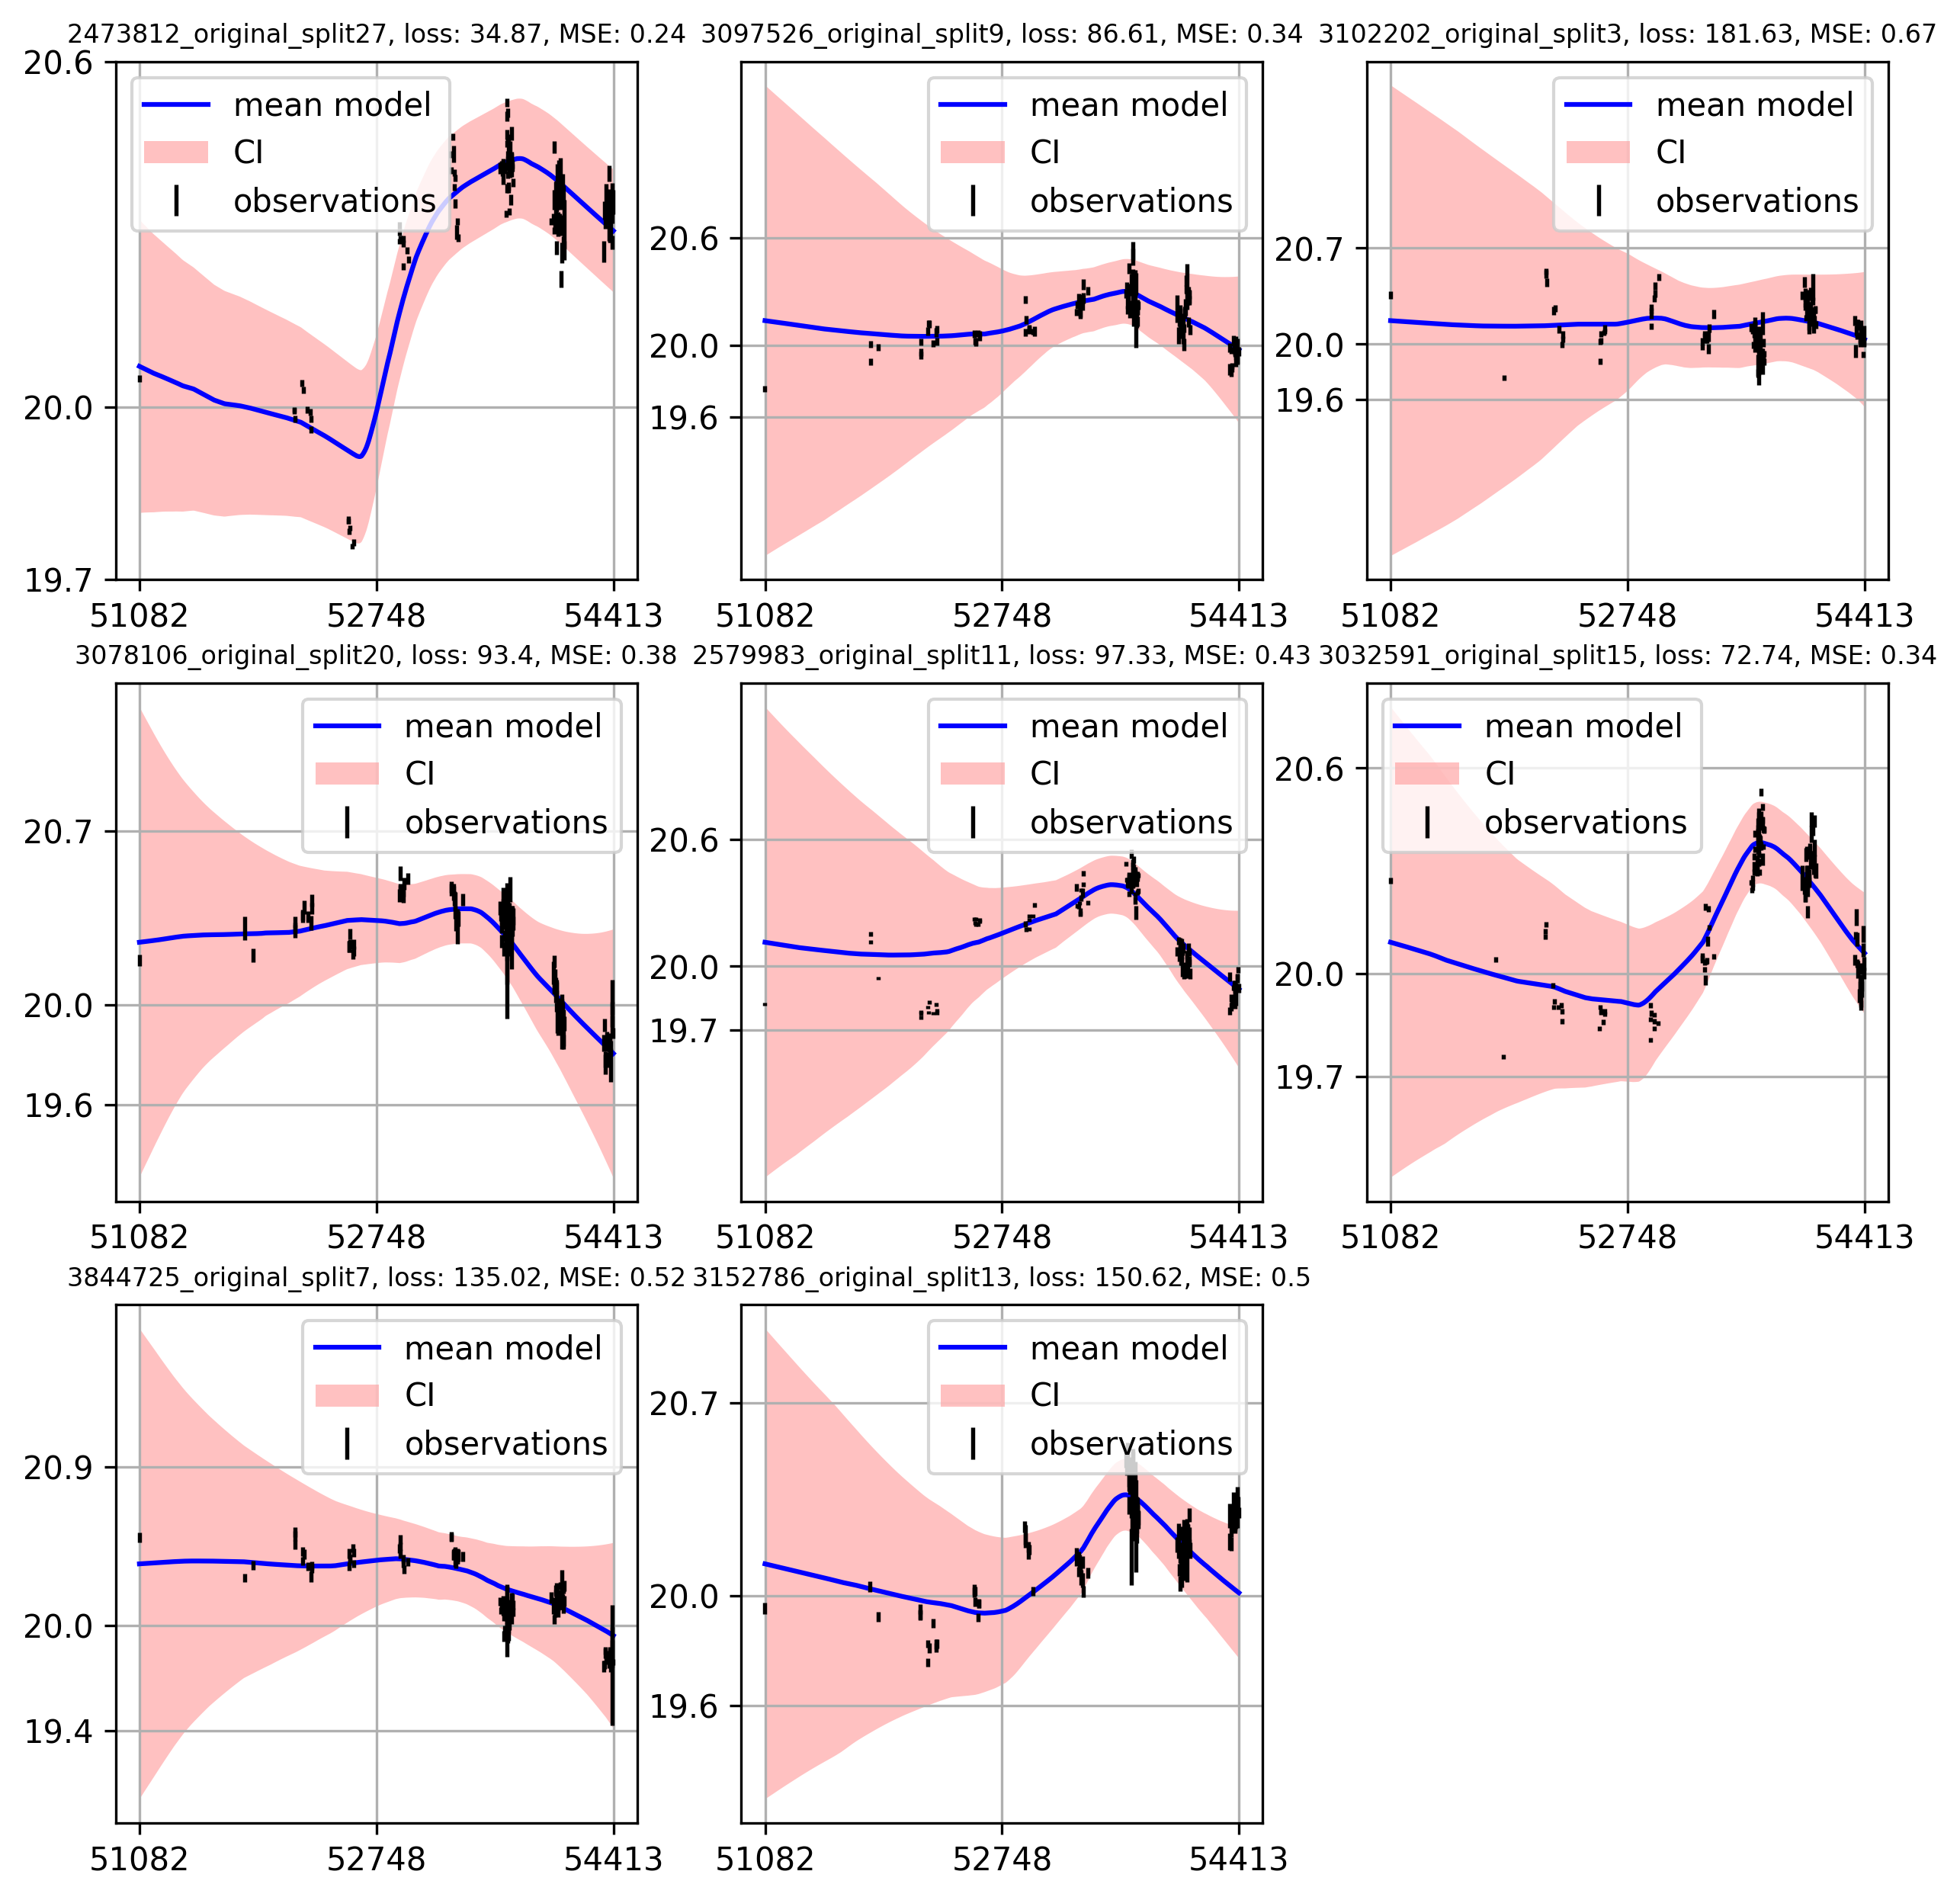

In [40]:
#prediction and plotting train data
trainMetrics=pop.plot_train_light_curves(model, trainLoader, criterion, mseMetric, plot_function2, device,tr)

In [41]:
savetrain=pop.save_train_metrics(OUTPUT_PATH, trainMetrics)#saving train metrics

100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.03it/s]


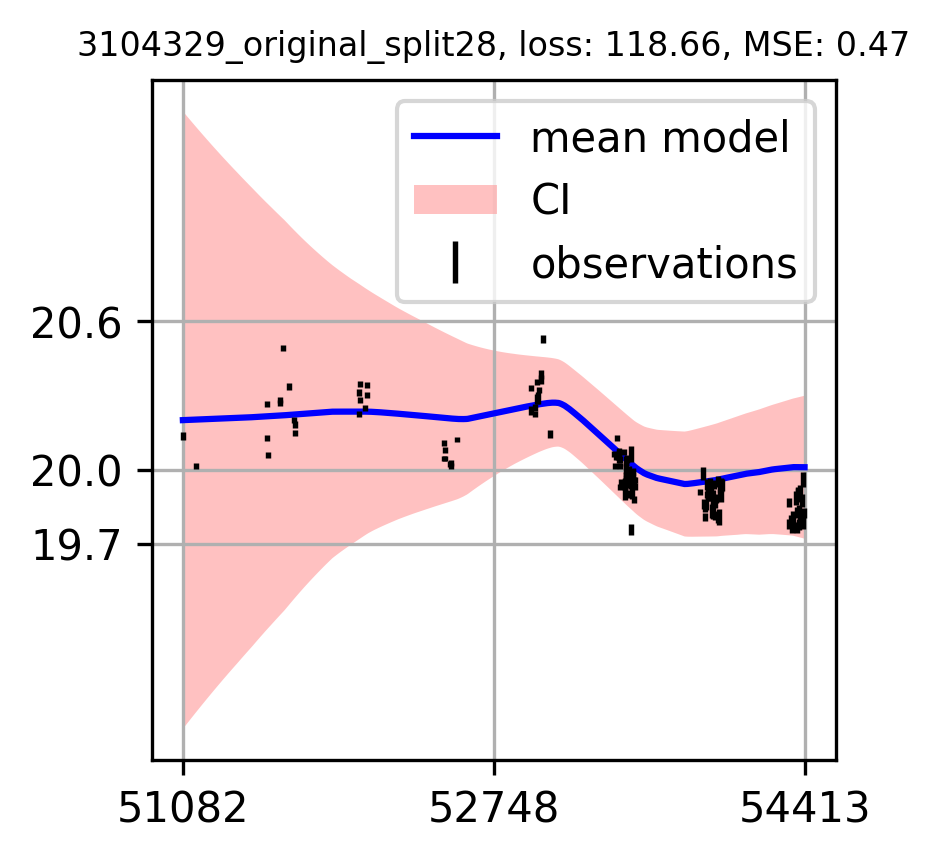

In [42]:
#prediction and plotting val data
valMetrics=pop.plot_val_light_curves(model, valLoader, criterion, mseMetric, plot_function2, device,tr)

In [43]:
saveval=pop.save_val_metrics(OUTPUT_PATH, valMetrics)#saving the val metrics